<a href="https://colab.research.google.com/github/mahault/Multi-agent-sustainability/blob/main/Sust_AIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling Sustainable Resource Management Using AIF**
---
*Mahault Albarracin, Maria Raffa, Paul Kinghorn*
--
*Based on Sussex University ICAM Lab and Filippo Torresan's hints*


The following code in progress is the first step towards simulating sustainability under AIF.

In order to deal with sustainability in a very straightforward way, we start by thinking of a simple model, i.e. an agent that is able to sustain itself by learning how to use the resources at its disposal wisely. The agent is in a certain place and has to decide whether or not to eat food that is in the same place, at different time steps.

The agent should learn that it does not have to satisfy its greed immediately, even if it is very hungry, because the aim is to maintain a balance between itself and the environment (i.e. a room with food) as long as possible over time. In this case, it learns to align available resources with its needs.

**Case 1** is the baseline to be sure the model works as intended, and considers a static environment. It refers to an agent deciding whether to eat food or not. It should result in an agent that keeps eating, in an environment where food is always present. We assume the agent is aware of its own location and knows that food is in the same location as it is as well, so it has perfect knowledge of the environment.

**Case 2** considers a dynamic environment, where the agent should learn how to not be greedy over time, i.e. food increases when the agent does not eat.

In [ ]:
# Import necessary libraries
!pip install inferactively-pymdp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp

In [ ]:
from pymdp import inference, control, learning
from pymdp import utils, maths
from pymdp.maths import softmax
from pymdp.agent import Agent

In [ ]:
#!pip show pymdp

In [ ]:
from matplotlib.cm import Blues
from matplotlib.colors import Normalize

# **Case 1** - ok
-----
Baseline to ensure the model works as intended.

**Static environment**: the food is always present and the agent just decides whether to eat or not.

**Expected result**: the agent always eats whenever it is hungry.


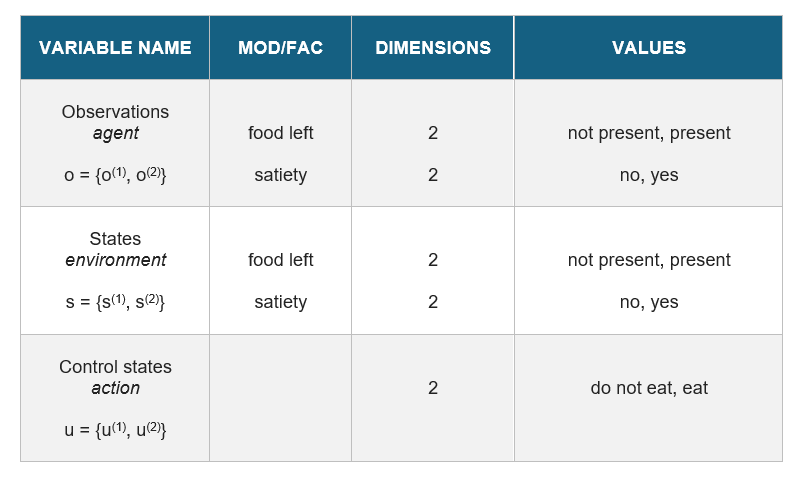

## **Generative model**

In [ ]:
# observations
obs_food = ['not present', 'present']
obs_satiety = ['no', 'yes']

# states
s_food = ['not present', 'present']
s_satiety = ['no', 'yes']

# controls
choice = ['do not eat', 'eat']

In [ ]:
# observation modality dimensions
num_obs = [len(obs_food), len(obs_satiety)]

# hidden state factors and dimensions
num_states = [len(s_food), len(s_satiety)]
num_factors = [len(num_states)]

# control state factor dimensions
num_controls = [len(choice)]

In [ ]:
num_factors

[2]

In [ ]:
num_obs

[2, 2]

In [ ]:
num_states

[2, 2]

In [ ]:
num_controls

[2]

### Observation model (Perception) - *A matrix*
---

P (O|S)

x = State 0 food left

y = obs

z = State 1 satiety


In [ ]:
# one array for each obs
# the matrix has 2 rows (obs), 2 columns (state 0 type), 2 slices (state 1 type)

A = utils.initialize_empty_A(num_obs, num_states)

#### Food left observation





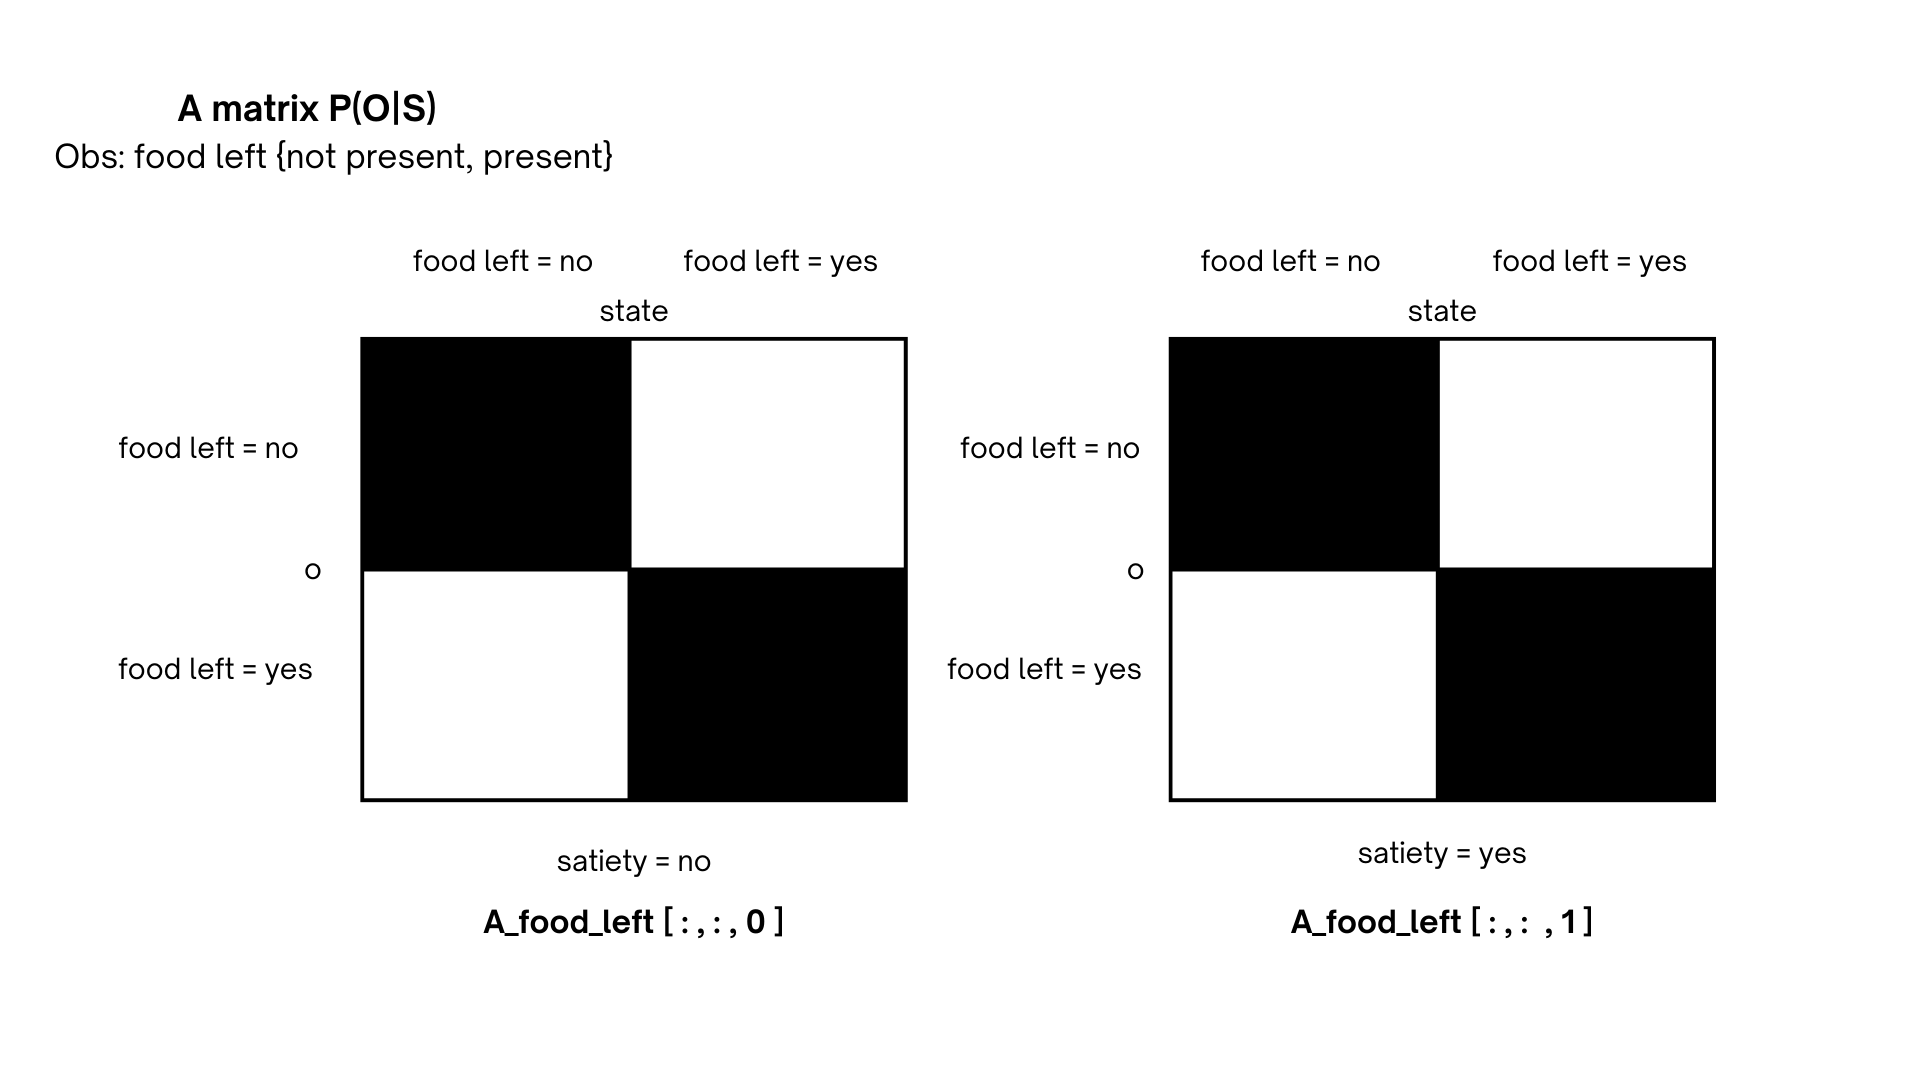

Both identities: food observation is the same with respect to food state.

In [ ]:
A_food_left = np.zeros((len(obs_food), len(s_food), len(s_satiety)))

In [ ]:
# State satiety = no -> A_food_left[:,:,0]

# index 1: obs food, index 2: state food, index 3: state satiety

# Obs food left = no (0), state food = not present (0), state satiety = no (0) should be 100% prob
A_food_left[0,0,0] = 1.0
print(A_food_left)

# Obs food left = yes (1), state food = not present (0), state satiety = no (0) should be 0%
A_food_left[1,0,0] = 0.0

# Obs food left = no (0), state food = present (1), state satiety = no (0) should be 0%
A_food_left[0,1,0] = 0.0

# Obs food left = yes (1), state food = present (1), state satiety = no (0) should be 100%
A_food_left[1,1,0] = 1.0

[[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


In [ ]:
print(A_food_left[1,0,0])

0.0


In [ ]:
A_food_left[:,:,0]

array([[1., 0.],
       [0., 1.]])

In [ ]:
# State satiety = yes -> A_food_left[:,:,1]

# Obs food left = no (0), state food = not present (0), state satiety = yes (1)
A_food_left[0,0,1] = 1.0

# Obs food left = yes (1), state food = not present (0), state satiety = yes (1) should be 0%
A_food_left[1,0,1] = 0.0

# Obs food left = no (0), state food = present (1), state satiety = yes (0) should be 0%
A_food_left[0,1,1] = 0.0

# Obs food left = yes (1), state food = present (1), state satiety = yes (1)
A_food_left[1,1,1] = 1.0

In [ ]:
A_food_left[:,:,1]

array([[1., 0.],
       [0., 1.]])

In [ ]:
A[0] = A_food_left

In [ ]:
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

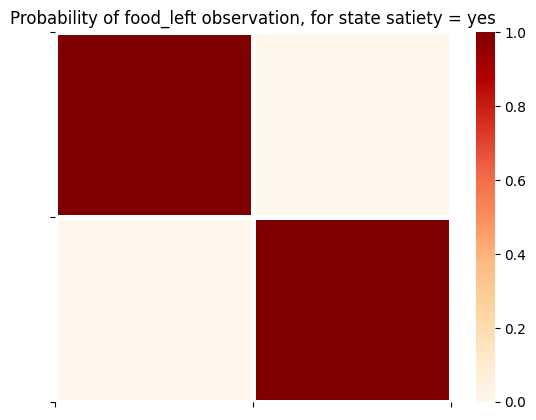

In [ ]:
utils.plot_likelihood(A[0][:,:,1], title = 'Probability of food_left observation, for state satiety = yes')

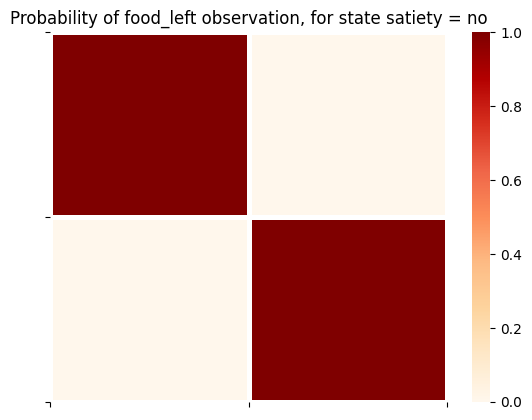

In [ ]:
utils.plot_likelihood(A[0][:,:,0], title = 'Probability of food_left observation, for state satiety = no')

It is an identity, since the food left obs does not depend on satiety.

#### Satiety observation


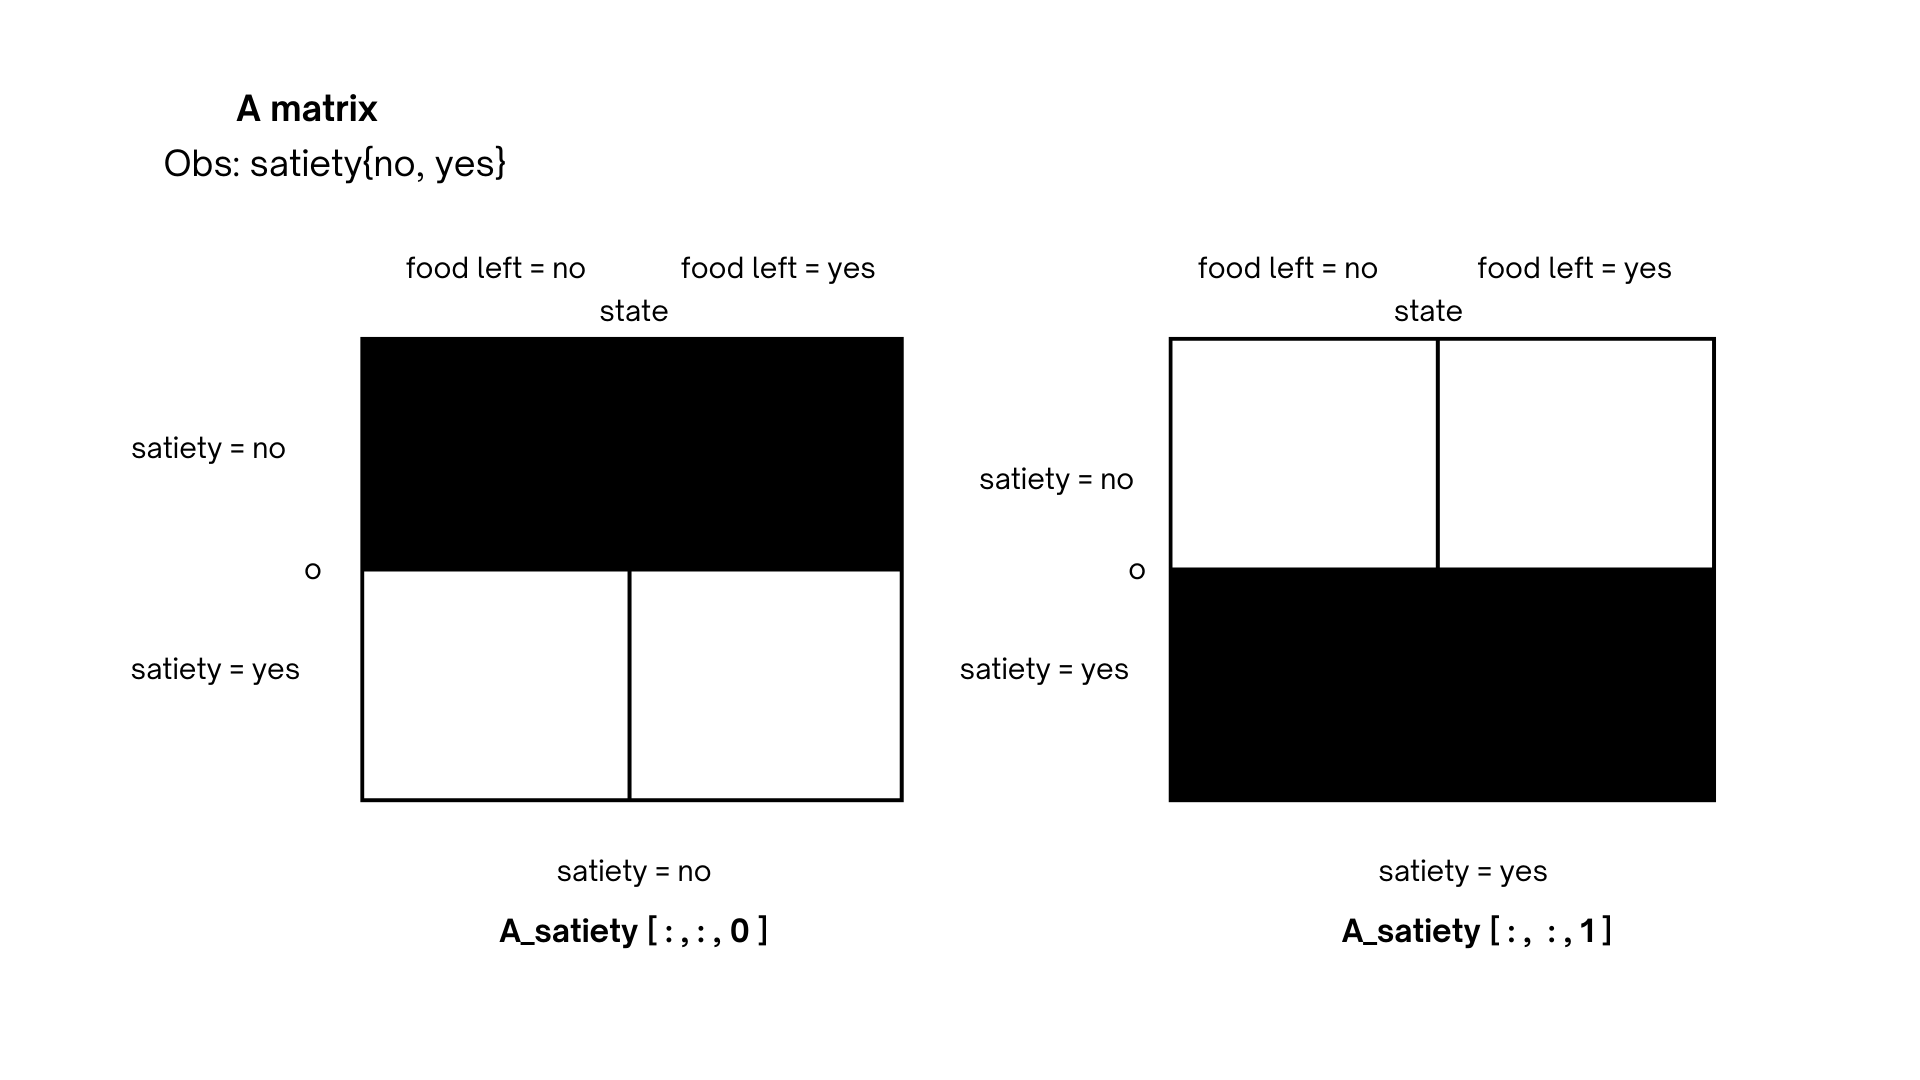

The agent is always hungry/not hungry, not depending on the observation of food.

In [ ]:
A_satiety = np.zeros((len(obs_satiety), len(s_food), len(s_satiety)))

In [ ]:
# State satiety = no -> A_satiety[:,:,0]
# State satiety = yes -> A_satiety[:,:,1]

# Obs satiety = no (0), state food = not present/present, state satiety = no (0)
A_satiety[0,:,0] = 1.0

# Obs satiety = yes (1), state food = not present/present, state satiety = no (0)
A_satiety[1,:,0] = 0.0

# Obs satiety = no (0), state food = not present/present, state satiety = yes (1)
A_satiety[0,:,1] = 0.0

# Obs satiety = yes (1), state food = not present/present, state satiety = yes (1)
A_satiety[1,:,1] = 1.0

In [ ]:
 A_satiety[:,:,0] # satiety = no

array([[1., 1.],
       [0., 0.]])

In [ ]:
A_satiety[:,:,1] # satiety = yes

array([[0., 0.],
       [1., 1.]])

In [ ]:
A_satiety[:,0,:]  # food = not present
                  # this should be identity

array([[1., 0.],
       [0., 1.]])

In [ ]:
A_satiety[:,1,:] # # food = present
                 # this should be identity

array([[1., 0.],
       [0., 1.]])

In [ ]:
A_satiety

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
 A[1] = A_satiety

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

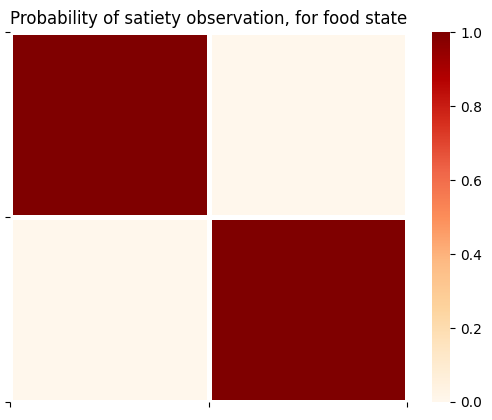

In [ ]:
utils.plot_likelihood(A[1][:,0,:], title = 'Probability of satiety observation, for food state')
                                   # this should be identity

The above are identity, since if food is not present the satiety is the same.

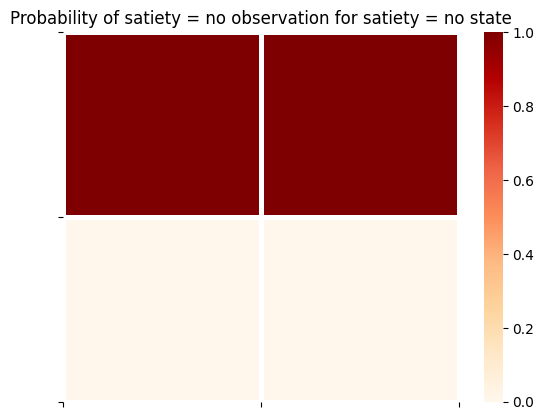

In [ ]:
utils.plot_likelihood(A[1][:,:,0], title = 'Probability of satiety = no observation for satiety = no state')

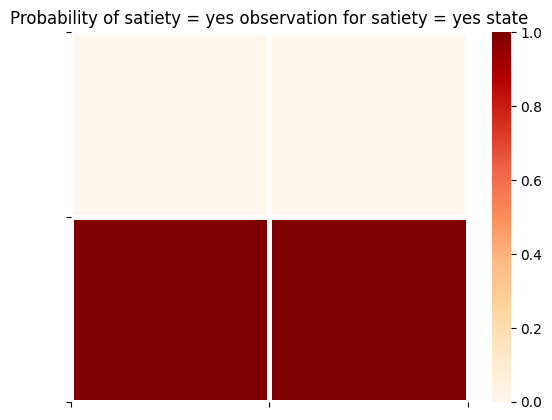

In [ ]:
utils.plot_likelihood(A[1][:,:,1], title = 'Probability of satiety = yes observation for satiety = yes state')

The agent is hungry/full when satiety state is no/yes, regardless food left.

In [ ]:
A

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
type(A)

numpy.ndarray

In [ ]:
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

In [ ]:
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = A.sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalized.")
else:
    print("The matrix is not normalized. Sums:", sums)

The matrix is not normalized. Sums: [[[2. 1.]
  [1. 0.]]

 [[0. 1.]
  [1. 2.]]]


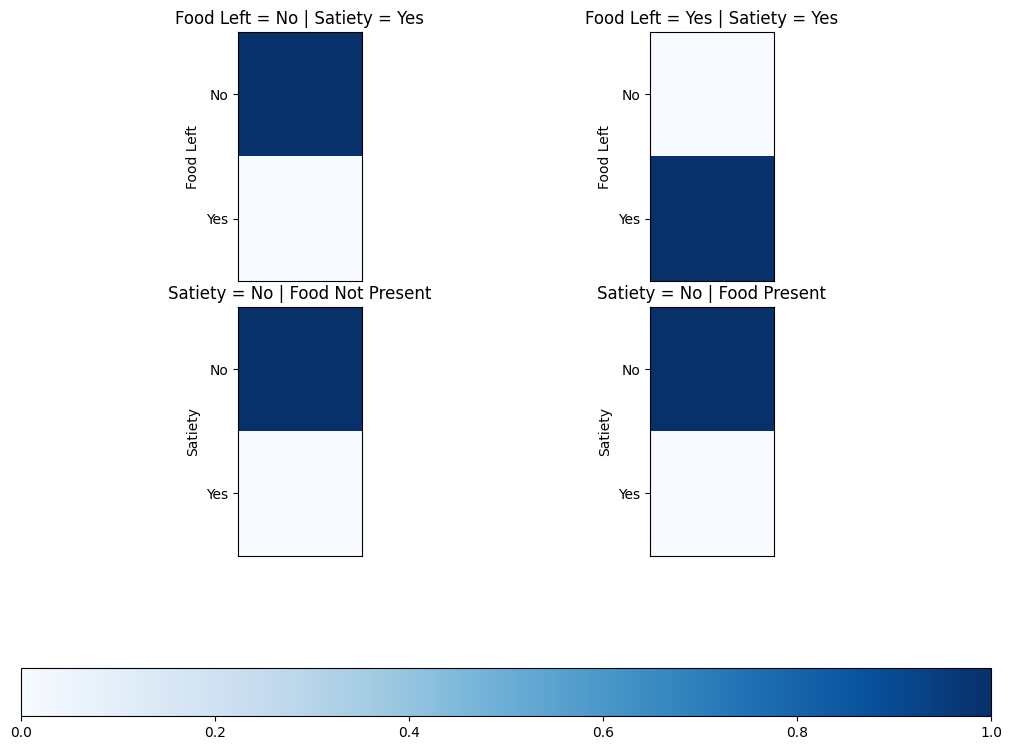

In [ ]:
# Plot both A_food_left and A_satiety together
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Titles for subplots
titles = ['Food Left = No | Satiety = Yes', 'Food Left = Yes | Satiety = Yes',
          'Satiety = No | Food Not Present', 'Satiety = No | Food Present']

# Plot for A_food_left
for i in range(2):
    im = axes[0, i].imshow(A_food_left[:, i, 1].reshape(2, 1), cmap='Blues', vmin=0, vmax=1)
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([0, 1])
    axes[0, i].set_yticklabels(['No', 'Yes'])
    axes[0, i].set_ylabel('Food Left')

# Plot for A_satiety
for i in range(2):
    im = axes[1, i].imshow(A_satiety[:, i, 0].reshape(2, 1), cmap='Blues', vmin=0, vmax=1)
    axes[1, i].set_title(titles[i+2])
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([0, 1])
    axes[1, i].set_yticklabels(['No', 'Yes'])
    axes[1, i].set_ylabel('Satiety')

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()

### Transition model (Planning) - *B matrix*
----

P(St|St-1, Ut-1)

x = State t-1

y = State t

z = Control state

---

We set the matrices so that the the environment does not change, and food is always present. The agent always has food available. Since there is not learning on the B matrix, this will not affect the AIF loop.

In [ ]:
# we need one slice matrix for each state
B = utils.initialize_empty_B(num_states, num_states)

In [ ]:
B

array([array([[[0., 0.],
               [0., 0.]],

              [[0., 0.],
               [0., 0.]]]), array([[[0., 0.],
                                    [0., 0.]],

                                   [[0., 0.],
                                    [0., 0.]]])], dtype=object)

#### Food left state

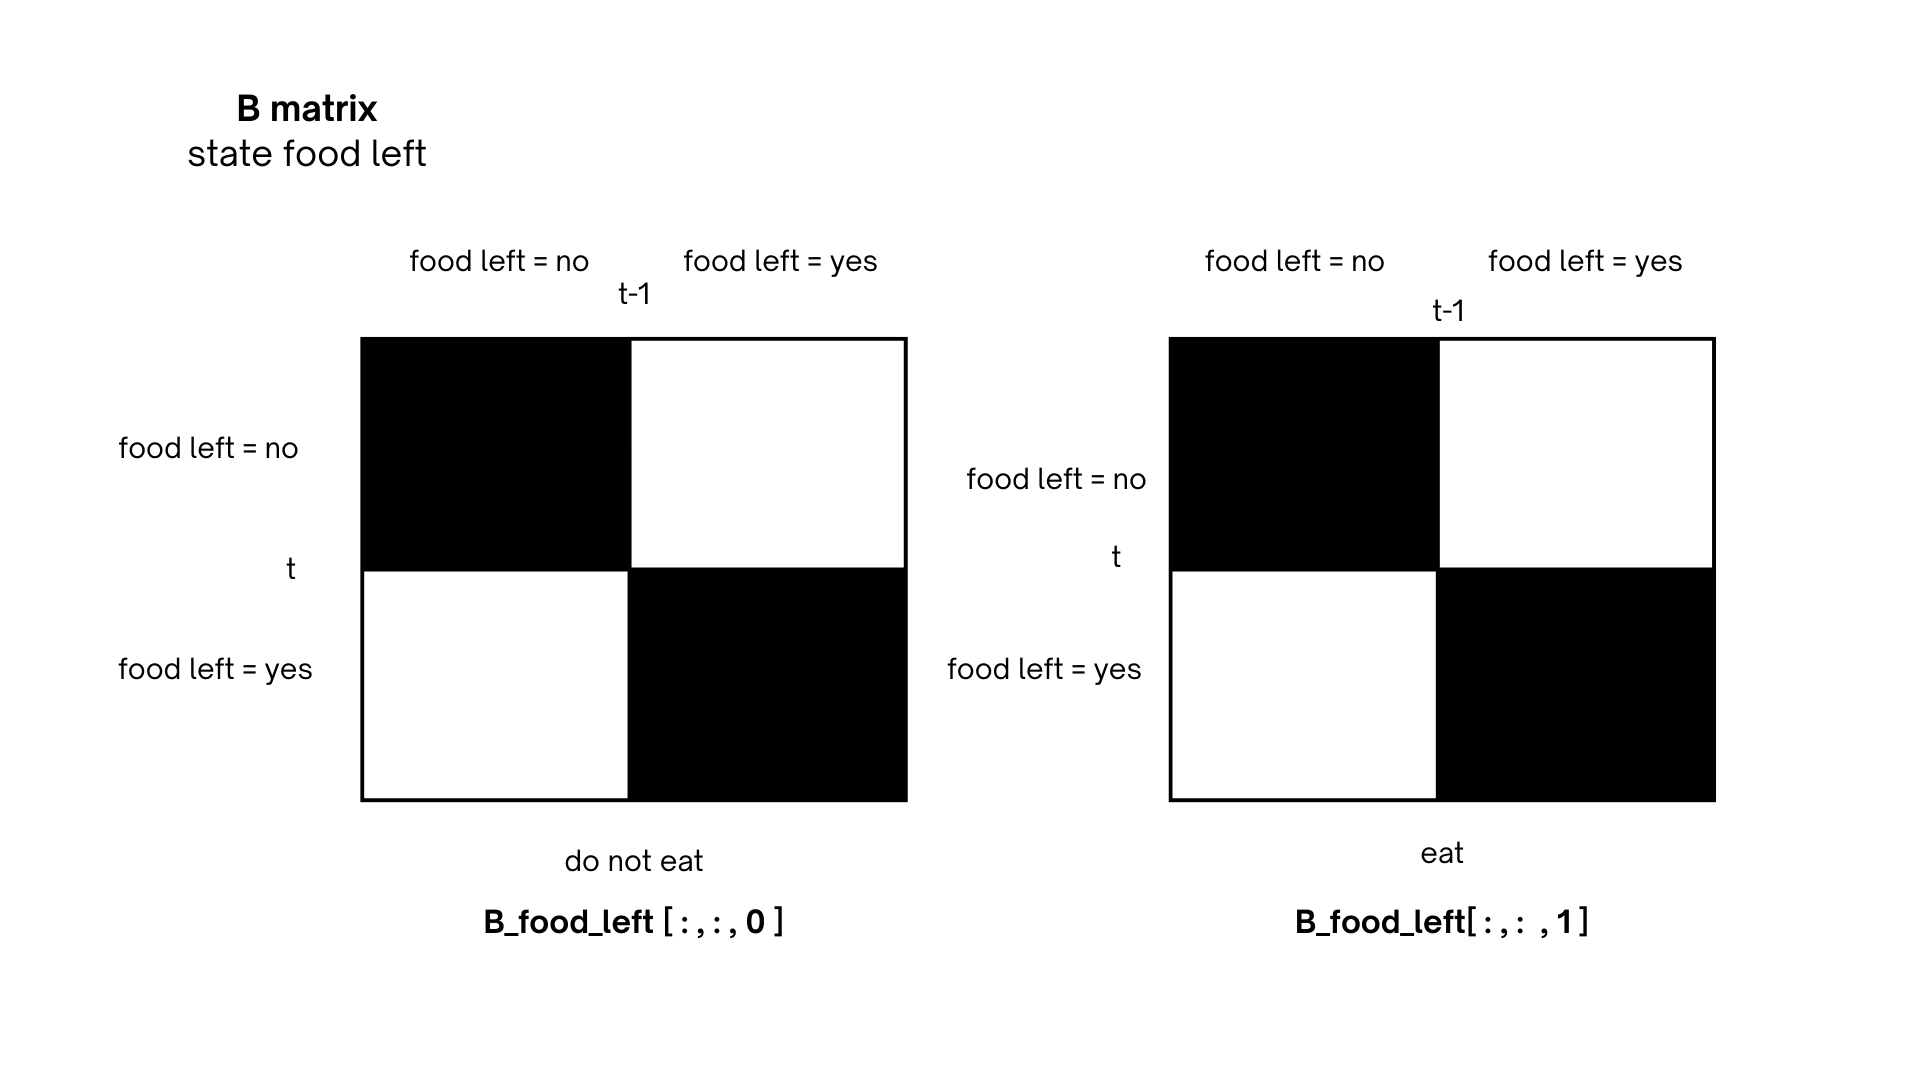

Both identities: food is always present, so there are no changes despite eating or not.

In [ ]:
B_food_left = np.zeros( (len(s_food), len(s_food), len(choice)) )

In [ ]:
# Action = do not eat -> B_food_left[:,:,0]
# Action = eat -> B_food_left[:,:,1]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = no (0), state t-1: food left = no (0), action = eat/not eat 100% prob
B_food_left[0,0,:] = 1.0

# state t: food left = yes (1), state t-1: food = no (0), action: eat/not eat 0%
B_food_left[1,0,:] = 0.0

# state t: food left = no (0), state t-1: food = yes (1), action: eat/not eat 0%
B_food_left[0,1,:] = 0.0

# state t: food left = yes (1), state t-1: food = yes (1), action: eat/not eat should be 100%
B_food_left[1,1,:] = 1.0

In [ ]:
B_food_left[:,:,0]

array([[1., 0.],
       [0., 1.]])

In [ ]:
B[0] = B_food_left

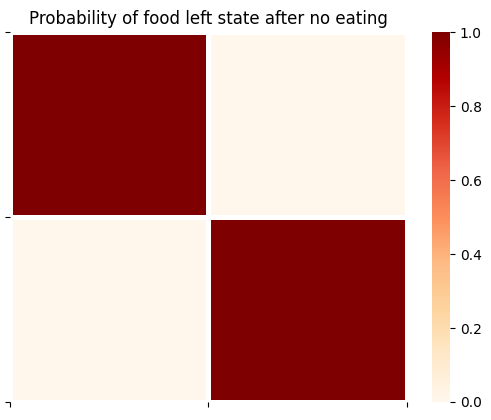

In [ ]:
utils.plot_likelihood(B[0][:,:,0], title = 'Probability of food left state after no eating' )

In [ ]:
B_food_left[:,:,1]

array([[1., 0.],
       [0., 1.]])

In [ ]:
B[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

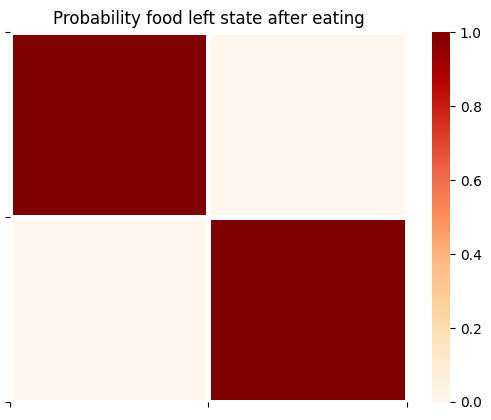

In [ ]:
utils.plot_likelihood(B[0][:,:,1], title = 'Probability food left state after eating' )

#### Satiety state

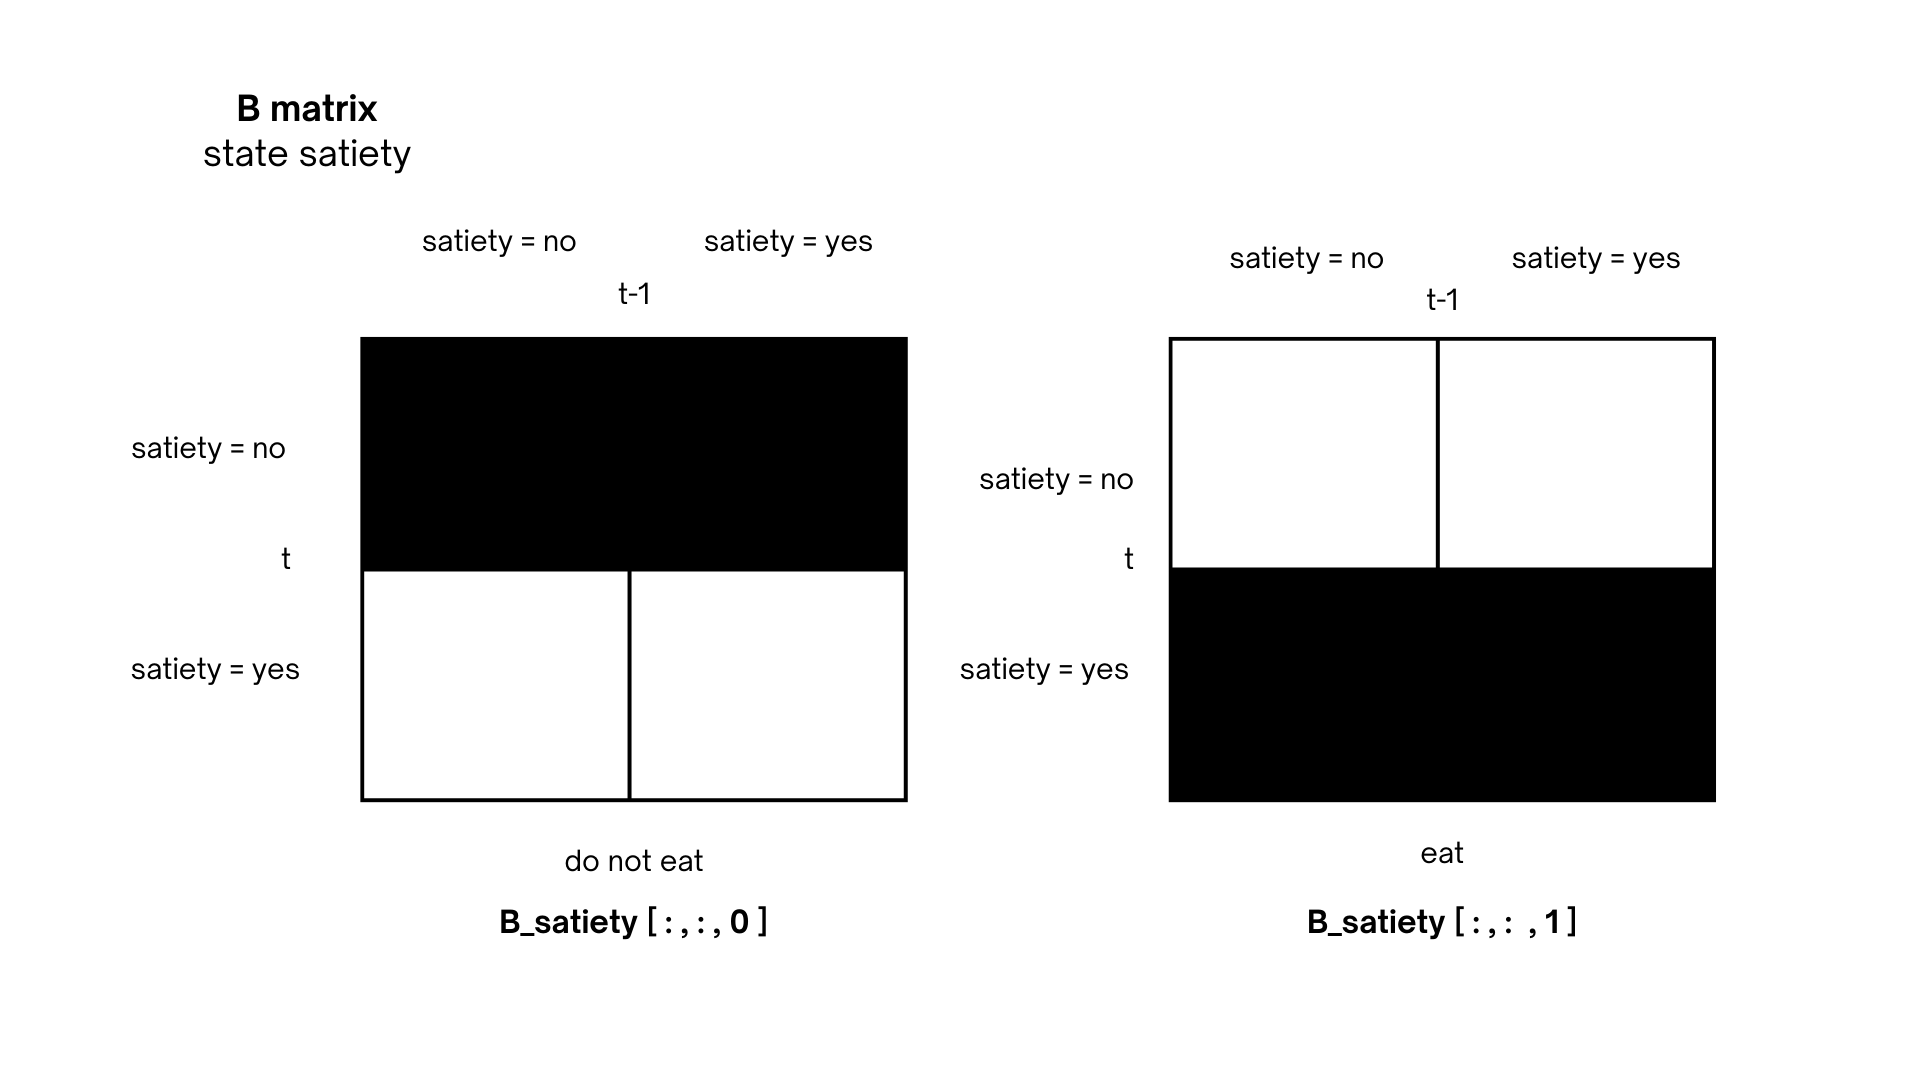

The agent is always hungry (satiety = no) after no eating and always full (satiety = yes) after eating.

In [ ]:
B_satiety = np.zeros( (len(s_satiety), len(s_satiety), len(choice)))

In [ ]:
# Action = do not eat -> B_satiety[:,:,0]
# Action = eat -> B_satiety[:,:,1]

#F index 1: state t, index 2: state t-1, index 3: action

# State t: satiety = no (0), state t-1: satiety = yes/no, action = do not eat (0)
B_satiety[0,:,0] = 1.0

# State t: satiety = yes (1), state t-1: satiety = yes/no, action: do not eat (0) should be 0%
B_satiety[1,:,0] = 0.0 # chances of being full when not  eating regardless of starting state is 0

# State t: satiety = no (0), state t-1: satiety = yes/no, action: do not eat (0) should be 0%
B_satiety[0,:,1] = 0.0

# State t: satiety = yes (1), state t-1: satiety = yes/no, action: do not eat (0) should be 100%
B_satiety[1,:,1] = 1.0 # chances of being full when eating regardless of starting state is 1

In [ ]:
B[1] = B_satiety

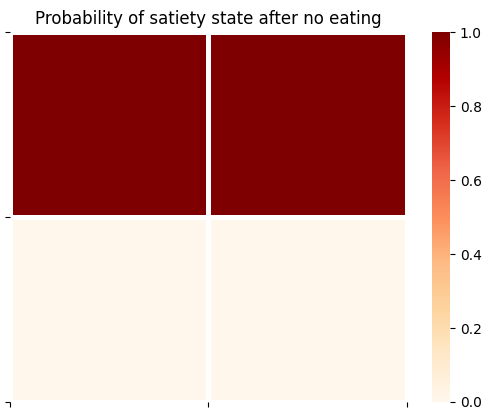

In [ ]:
# chances of being full when not  eating regardless of starting state is 0

utils.plot_likelihood(B[1][:,:,0], title = 'Probability of satiety state after no eating')

In [ ]:
B_satiety[:,:,1]

array([[0., 0.],
       [1., 1.]])

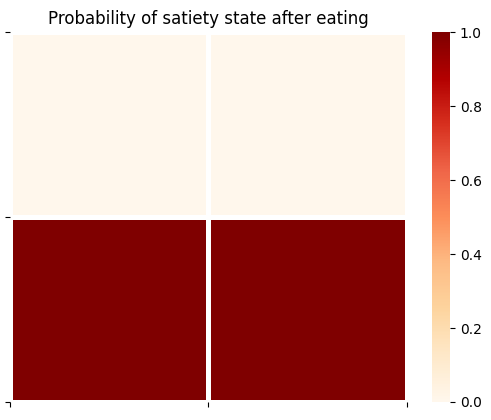

In [ ]:
# chances of being full when eating regardless of starting state is 1

utils.plot_likelihood(B[1][:,:,1], title = 'Probability of satiety state after eating' )

In [ ]:
B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
type(B)

numpy.ndarray

In [ ]:
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = B.sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalized.")
else:
    print("The matrix is not normalized. Sums:", sums)

The matrix is not normalized. Sums: [[[2. 1.]
  [1. 0.]]

 [[0. 1.]
  [1. 2.]]]


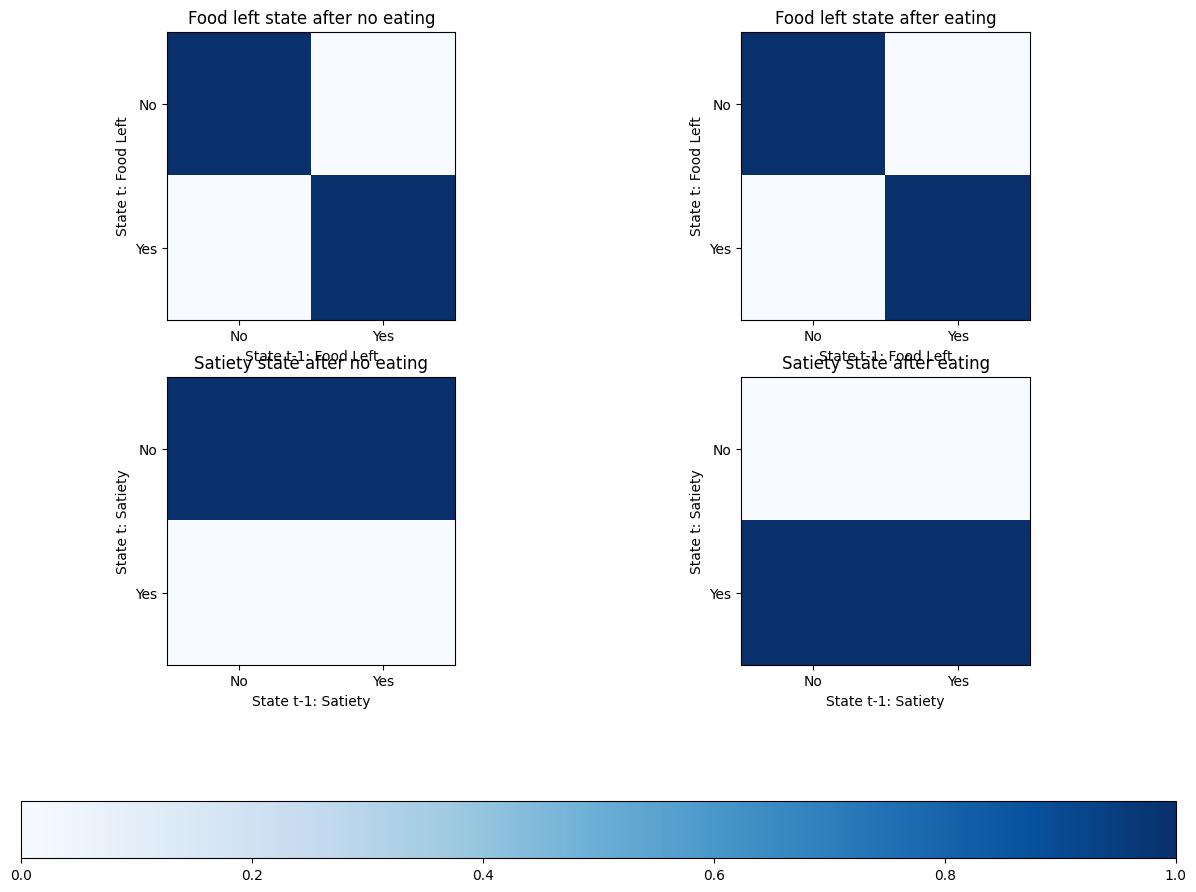

In [ ]:
# plot both B_food_left and B_satiety together

# Titles for each subplot
titles = [
    "Food left state after no eating",
    "Food left state after eating",
    "Satiety state after no eating",
    "Satiety state after eating"
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
action_labels = ['Do Not Eat', 'Eat']

for i in range(2):
    im = axes[0, i].imshow(B_food_left[:, :, i], cmap='Blues', vmin=0, vmax=1)
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xticks([0, 1])
    axes[0, i].set_yticks([0, 1])
    axes[0, i].set_xticklabels(['No', 'Yes'])
    axes[0, i].set_yticklabels(['No', 'Yes'])
    axes[0, i].set_xlabel('State t-1: Food Left')
    axes[0, i].set_ylabel('State t: Food Left')

    im = axes[1, i].imshow(B_satiety[:, :, i], cmap='Blues', vmin=0, vmax=1)
    axes[1, i].set_title(titles[i + 2])
    axes[1, i].set_xticks([0, 1])
    axes[1, i].set_yticks([0, 1])
    axes[1, i].set_xticklabels(['No', 'Yes'])
    axes[1, i].set_yticklabels(['No', 'Yes'])
    axes[1, i].set_xlabel('State t-1: Satiety')
    axes[1, i].set_ylabel('State t: Satiety')

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()


### Prior preferences and beliefs


#### *C vector*
We set an agent that has a strong preference for being full (*satiety* = yes) and *food_left* = present.

In [ ]:
# create prior preferences over observations (C vector)
# our agent has a strong preference for obs satiety = yes

C = utils.obj_array_zeros([num_obs])

In [ ]:
# Define preferences for each observation modality
# index 1: mod not present/no, index 2: mod present/yes C[0][:,1] C[1][:,1]

C_food_left = np.array([0.0, 20.0])  # preference for the observation modality of food present
C_satiety = np.array([0.0, 20.0])  # preference for the observation modality of satiety

# create an object array to hold each modality's preferences
C = np.empty(2, dtype=object)
C[0] = C_food_left
C[1] = C_satiety

In [ ]:
C

array([array([ 0., 20.]), array([ 0., 20.])], dtype=object)

In [ ]:
len(C)

2

In [ ]:
type(C)

numpy.ndarray

In [ ]:
print("C vector:", C)
for i, pref in enumerate(C):
    print(f"Preferences for modality {i}: {pref}") #modality 0: food_left; 1: satiety

C vector: [array([ 0., 20.]) array([ 0., 20.])]
Preferences for modality 0: [ 0. 20.]
Preferences for modality 1: [ 0. 20.]


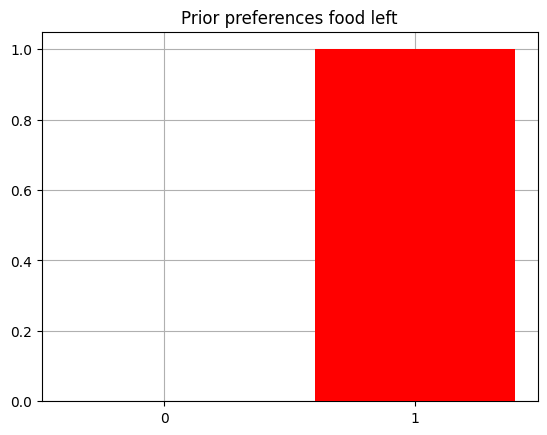

In [ ]:
utils.plot_beliefs(softmax(C[0]), title = "Prior preferences food left")

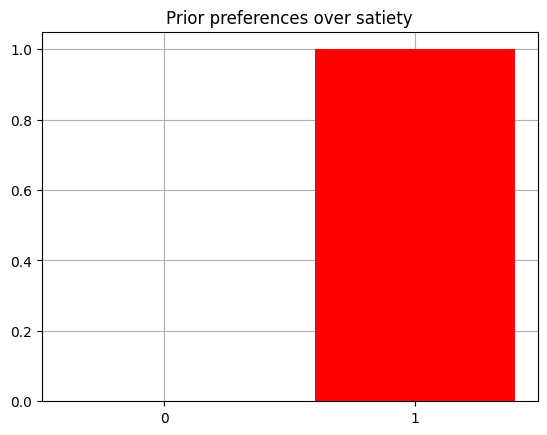

In [ ]:
utils.plot_beliefs(softmax(C[1]), title = "Prior preferences over satiety")

#### *D vector*

At t = 0 we set strong beliefs for *food_left* = present and *satiety* = no.

In [ ]:
# specify prior over hidden states (D vector)

D = utils.obj_array(num_factors)

In [ ]:
# we set at t = 0 strong beliefs over hidden state food left = yes D[0][:,1] and satiety = no D[1][0,:]

D_food_left = np.array([0.0, 20.0])
D_satiety = np.array([20.0, 0.0])

# create an object array to hold each modality's preferences
D = np.empty(2, dtype=object)
D[0] = D_food_left
D[1] = D_satiety

In [ ]:
D[1]

array([20.,  0.])

In [ ]:
type(D)

numpy.ndarray

In [ ]:
print("D vector:", D)
for i, prior in enumerate( D):
    print(f"Prior over factor {i}: {prior}")

D vector: [array([ 0., 20.]) array([20.,  0.])]
Prior over factor 0: [ 0. 20.]
Prior over factor 1: [20.  0.]


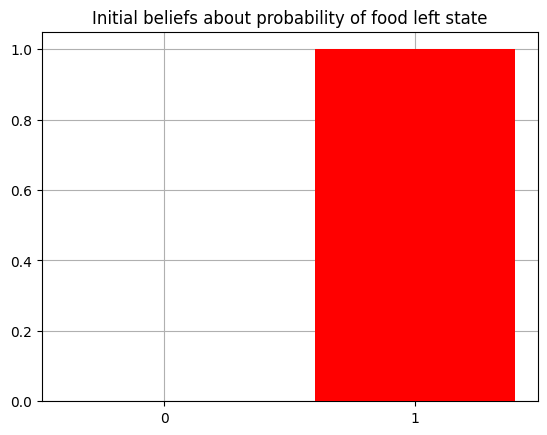

In [ ]:
utils.plot_beliefs(softmax(D[0]), title = "Initial beliefs about probability of food left state")

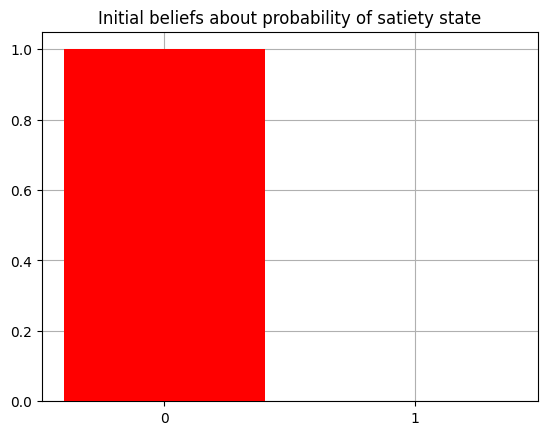

In [ ]:
utils.plot_beliefs(softmax(D[1]), title = "Initial beliefs about probability of satiety state")

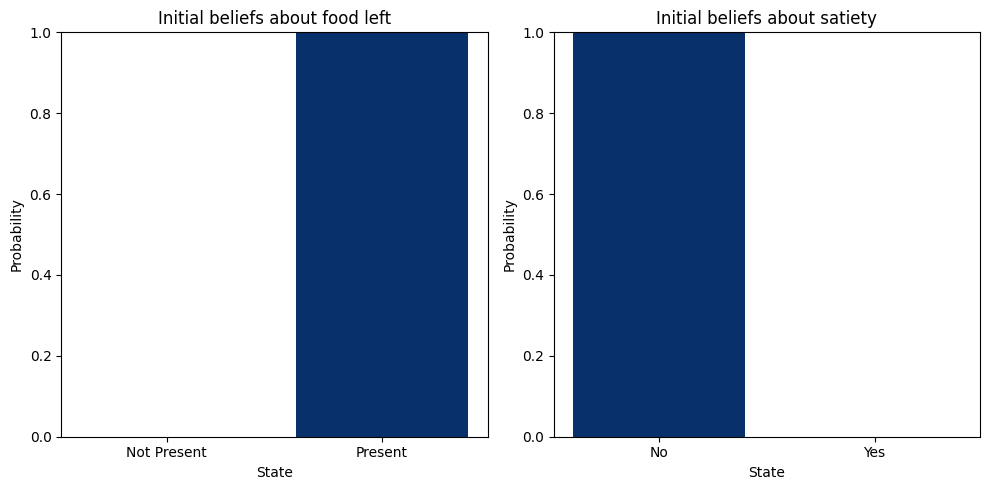

In [ ]:
# normalize object to map the data values to the color map scale
norm = Normalize(vmin=0, vmax=1)

# setting up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plotting the beliefs for food left
colors_food = [Blues(norm(value)) for value in D[0]]  # Get colors from the Blues colormap
axes[0].bar(['Not Present', 'Present'], D[0], color=colors_food)
axes[0].set_title('Initial beliefs about food left')
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('State')

# plotting the beliefs for satiety
colors_satiety = [Blues(norm(value)) for value in D[1]]  # Get colors from the Blues colormap
axes[1].bar(['No', 'Yes'], D[1], color=colors_satiety)
axes[1].set_title('Initial beliefs about satiety')
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('State')

plt.tight_layout()
plt.show()


## **Generative Process**

### Agent

We set the agents beliefs matching the actual structure of the environment: food present and satiety no

In [ ]:
my_agent = Agent(A=A, B=B, C=C, policies=None, action_selection="stochastic")

In [ ]:
my_agent.policy_len #for case 2 agent should be 3

1

In [ ]:
my_agent.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_agent.policies=[np.array([[0,0]]),np.array([[1,1]])] # we need to change the policies, from 4 to 2, so that the agent takes one action only
my_agent.E = my_agent._construct_E_prior() # we adjust the E matrix size after having changed policies

In [ ]:
#my_agent.policies.pop(1)
#my_agent.policies.pop(1)

In [ ]:
my_agent.policies

[array([[0, 0]]), array([[1, 1]])]

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
C

array([array([ 0., 20.]), array([ 0., 20.])], dtype=object)

In [ ]:
D

array([array([ 0., 20.]), array([20.,  0.])], dtype=object)

### AIF loop

In [ ]:
from pymdp.envs import Env

In [ ]:
# class for the room environment (generative process)
class room_Env(Env):

    def __init__(self):

        # initial states
        self.state_food = 1 # food present
        self.state_satiety = 0 # no satiety

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        print(action)
        if action == 0:  # do not eat
            # state does not change
            self.state_food = 1
            self.state_satiety = 0


        elif action == 1: # eat
            # food becomes 'not present', satiety 'yes'
            self.state_food = 0
            self.state_satiety=1

        # mapping states to observations
        obs_food = self.state_food  # directly use the state as observation
        obs_satiety = self.state_satiety

        obs = [obs_food, obs_satiety]

        return obs

# function to restart the loop
    def reset(self):
        # reset the environment to the initial state
        self.state_food = 1 #food left present
        self.state_satiety = 0 #no satiety

        states = [self.state_food, self.state_satiety]

        return states

In [ ]:
env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_agent.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_agent.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_agent.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_agent.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [0, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [0, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [0, 1]



As expected, the agent keeps eating.

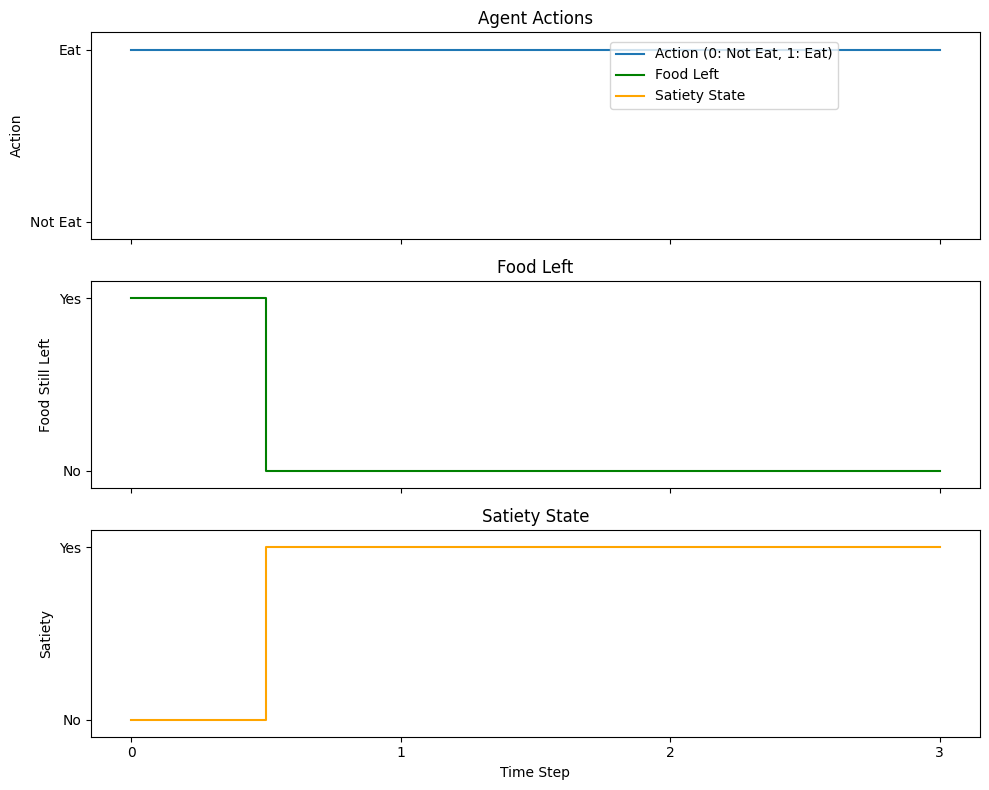

In [ ]:
#plot

# Time steps
T = 4

# data from output above
actions = np.array([1, 1, 1, 1])  # All actions are 'eat' (1)
observations_food = np.array([1, 0, 0, 0])  # First observation has food, then no food
observations_satiety = np.array([0, 1, 1, 1])  # Satiety changes to 1 after first action
agent_beliefs = np.array([1.0, 1.0, 1.0, 1.0])  # Agent's belief in the action taken

# plot
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting actions
ax[0].step(range(T), actions, label='Action (0: Not Eat, 1: Eat)', where='mid')
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_ylabel("Action")
ax[0].set_title("Agent Actions")
ax[0].set_yticks([0, 1])
ax[0].set_yticklabels(["Not Eat", "Eat"])

# plotting food observations
ax[1].step(range(T), observations_food, label='Food Left', where='mid', color='green')
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel("Food Still Left")
ax[1].set_title("Food Left")
ax[1].set_yticks([0, 1])
ax[1].set_yticklabels(["No", "Yes"])

# plotting satiety observations
ax[2].step(range(T), observations_satiety, label='Satiety State', where='mid', color='orange')
ax[2].set_ylim(-0.1, 1.1)
ax[2].set_ylabel("Satiety")
ax[2].set_title("Satiety State")
ax[2].set_yticks([0, 1])
ax[2].set_yticklabels(["No", "Yes"])

# setting x-axis properties
plt.xlabel("Time Step")
plt.xticks(range(T))

# adding a legend
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.95))

plt.tight_layout()
plt.show()

# **Case 2** - in progress
-----
**Dynamic environment**: food is depleted if the agent eats, grows if it does not eat.The agent should learn how to not be greedy over time.
This might be done by giving more dimensions to hidden states *food_left* and *satiety*.

Over successive timesteps, the agent updates its beliefs about the hidden states using its observations and the A matrix (perception). It then selects actions based on how it expects they will impact future states and observations, as captured in the B matrix (planning). By simulating this perception-action loop under the active inference framework, we can study the emergence of sustainable resource management strategies.

**Expected result**: the agent learns adjusting its eating
behavior according to the food replenishment rate. Consuming whenever food is present, may lead to periods of starvation while waiting for food to reappear.
An optimal strategy would involve more conservative eating to sustain a steady level of satiety over time.


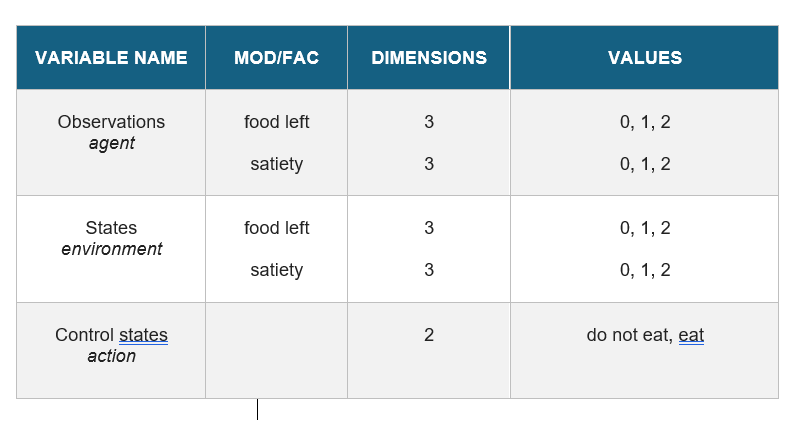

## **Generative model**

In [ ]:
# observations
obs_food2 = [0 , 1 , 2]
obs_satiety2 = [0 , 1 , 2]

# states
s_food2 = [0 , 1 , 2]
s_satiety2 = [0 , 1, 2]

# controls
choice2 = ['do not eat', 'eat']

In [ ]:
# observation modality dimensions
num_obs2 = [len(obs_food2), len(obs_satiety2)]

# hidden state factors and dimensions
num_states2 = [len(s_food2), len(s_satiety2)]
num_factors2 = [len(num_states2)]

# control state factor dimensions
num_controls2 = [len(choice2)]

In [ ]:
num_factors2

[2]

In [ ]:
num_obs2

[3, 3]

In [ ]:
num_states2

[3, 3]

In [ ]:
num_controls2

[2]

### Observation model (Perception) - *A matrix*

In [ ]:
A2 = utils.initialize_empty_A(num_obs2, num_states2)

#### Food left observation

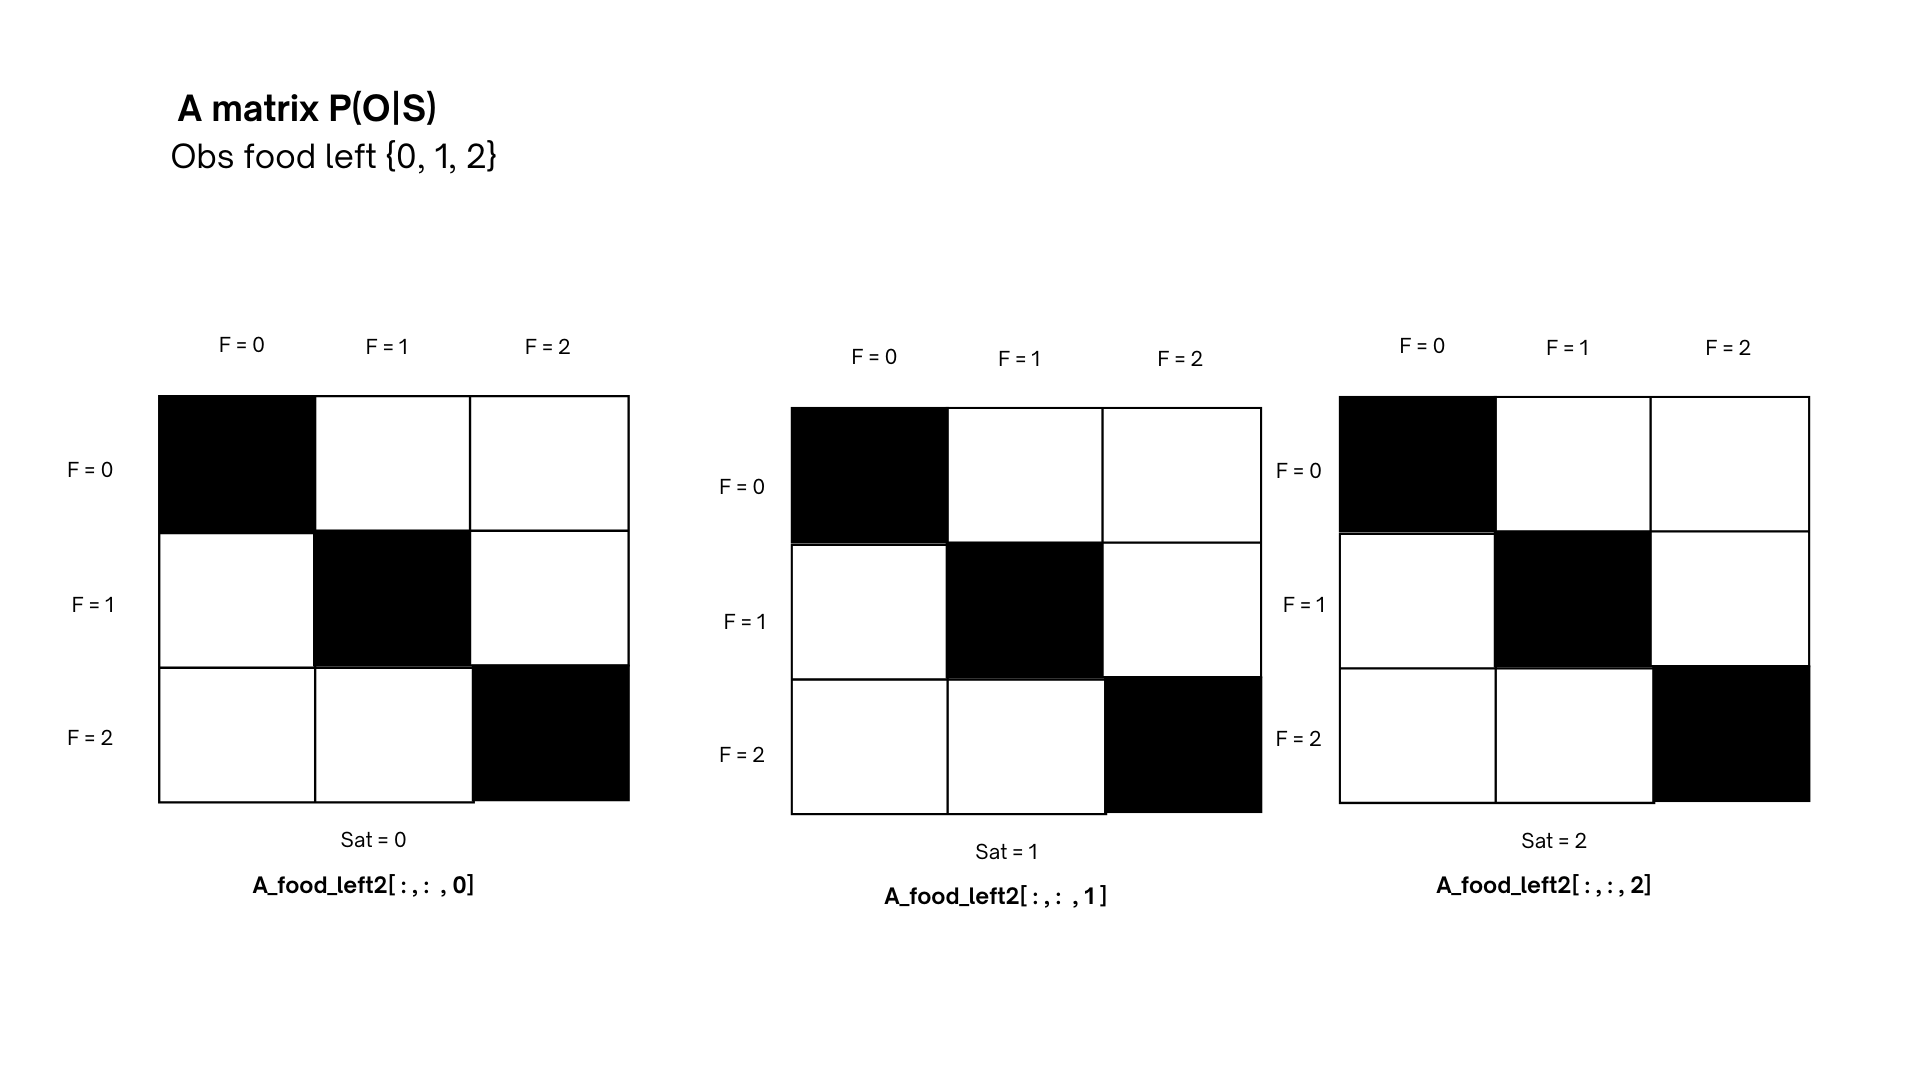

In [ ]:
A_food_left2 = np.zeros((len(obs_food2), len(s_food2), len(s_satiety2)))

In [ ]:
A_food_left2.shape

(3, 3, 3)

In [ ]:
# State satiety = 0 -> A_food_left2[:,:,0]

# index 1: obs food, index 2: state food, index 3: state satiety

# Obs food left = 0, state food = 0, state satiety = 0 should be 100% prob
A_food_left2[0,0,0] = 1.0

# Obs food left = 1, state food = 0, state satiety = 0 should be 0%
A_food_left2[1,0,0] = 0.0

# Obs food left = 2, state food = 0, satiety = 0
A_food_left2[2,0,0] = 0.0

# Obs food left = 0, state food = 1, state satiety = 0 should be 0%
A_food_left2[0,1,0] = 0.0

# Obs food left = 1, state food = 1, state satiety = 0 should be 100%
A_food_left2[1,1,0] = 1.0

#Obs food left = 2, state food = 1, satiety = 0
A_food_left2[2,1,0] = 0

#Obs food left = 2, state food = 2, satiety = 0
A_food_left2[2,2,0] = 1.0


In [ ]:
A_food_left2[:,:,0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# State satiety = 1 -> A_food_left2[:,:,1]

# Obs food left = 0, state food = 0, state satiety = 1 should be 100% prob
A_food_left2[0,0,1] = 1.0

# Obs food left = 1, state food = 0, state satiety = 1 should be 0%
A_food_left2[1,0,1] = 0.0

# Obs food left = 2, state food = 0, satiety = 1
A_food_left2[2,0,1] = 0.0

# Obs food left = 0, state food = 1, state satiety = 1 should be 0%
A_food_left2[0,1,1] = 0.0

# Obs food left = 1, state food = 1, state satiety = 1 should be 100%
A_food_left2[1,1,1] = 1.0

# Obs food left = 2, state food = 1, satiety = 1
A_food_left2[2,1,1] = 0

#Obs food left = 2, state food = 2, satiety = 1
A_food_left2[2,2,1] = 1.0

In [ ]:
A_food_left2[:,:,1]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# State satiety = 2 -> A_food_left2[:,:,2]


# Obs food left = 0, state food = 0, state satiety = 2 should be 100% prob
A_food_left2[0,0,2] = 1.0

# Obs food left = 1, state food = 0, state satiety = 2 should be 0%
A_food_left2[1,0,2] = 0.0

# Obs food left = 2, state food = 0, satiety = 2
A_food_left2[2,0,2] = 0.0

# Obs food left = 0, state food = 1, state satiety = 2 should be 0%
A_food_left2[0,1,2] = 0.0

# Obs food left = 1, state food = 1, state satiety = 2 should be 100%
A_food_left2[1,1,2] = 1.0

#Obs food left = 2, state food = 1, satiety = 2
A_food_left2[2,1,2] = 0

# Obs food left = 2, state food = 2, satiety = 2
A_food_left2[2,2,2] = 1.0

In [ ]:
A_food_left2[:,:,2]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
A2[0] = A_food_left2

In [ ]:
A2[0]

array([[[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]]])

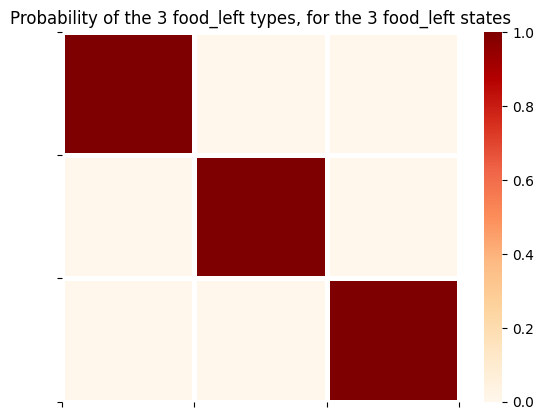

In [ ]:
utils.plot_likelihood(A2[0][:,:,1], title = 'Probability of the 3 food_left types, for the 3 food_left states')

#### Satiety observation


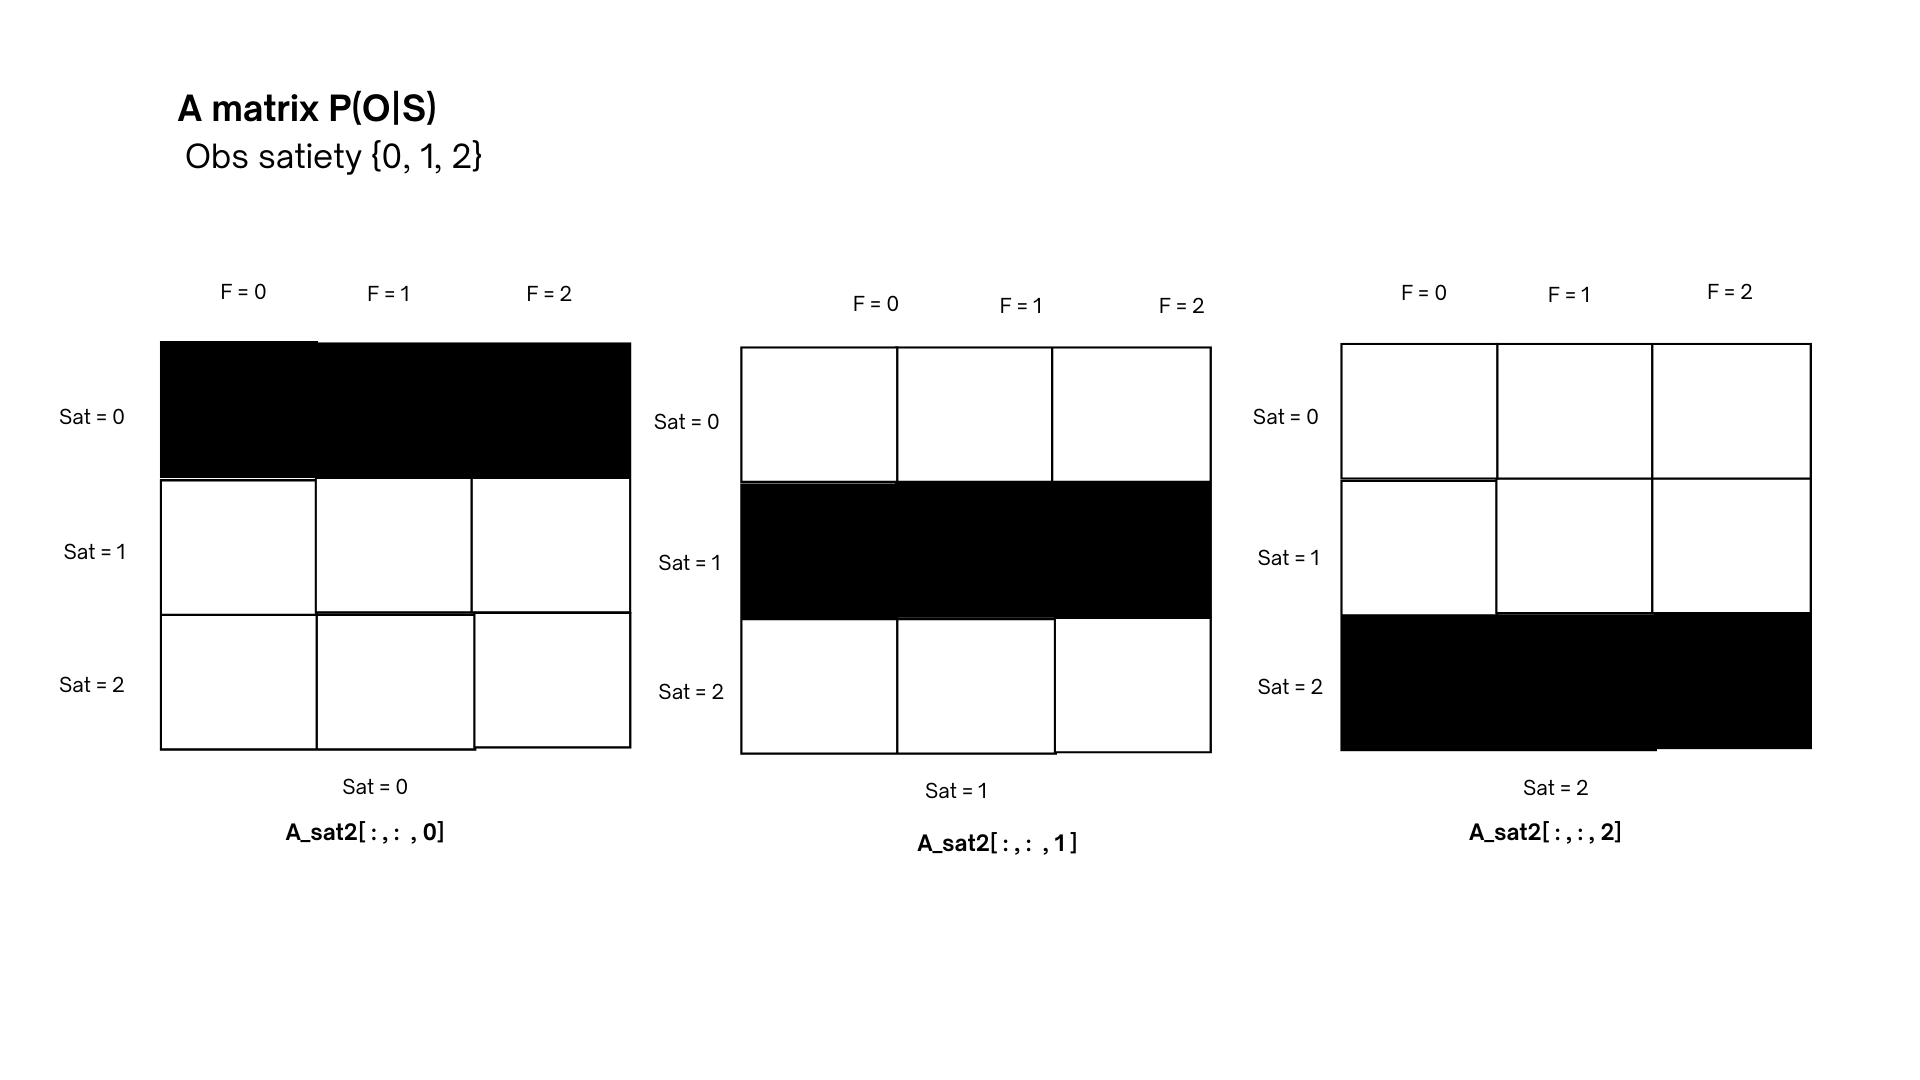

In [ ]:
A_satiety2 = np.zeros((len(obs_satiety2), len(s_food2), len(s_satiety2)))

In [ ]:
# State satiety = 0 -> A_satiety2[:,:,0]
# State satiety = 1 -> A_satiety2[:,:,1]
# State satiety = 2 -> A_satiety2[:,:,2]

# Obs satiety = 0, state food = 0/1/2, state satiety = 0
A_satiety2[0,:,0] = 1.0

A_satiety2[1,:,0] = 0.0

A_satiety2[2,:,0] = 0.0

# Obs satiety = 0, state food = 0/1/2, state satiety = 1
A_satiety2[0,:,1] = 0.0

A_satiety2[1,:,1] = 1.0

A_satiety2[2,:,1] = 0.0

# Obs satiety = 0, state food = 0/1/2, state satiety = 2
A_satiety2[0,:,2] = 0.0

A_satiety2[1,:,2] = 0.0

A_satiety2[2,:,2] = 1.0

In [ ]:
A_satiety2.shape

(3, 3, 3)

In [ ]:
A_satiety2[:,:,1]

array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]])

In [ ]:
A2[1] = A_satiety2

In [ ]:
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = A2.sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalized.")
else:
    print("The matrix is not normalized. Sums:", sums)

The matrix is not normalized. Sums: [[[2. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[0. 1. 0.]
  [1. 2. 1.]
  [0. 1. 0.]]

 [[0. 0. 1.]
  [0. 0. 1.]
  [1. 1. 2.]]]


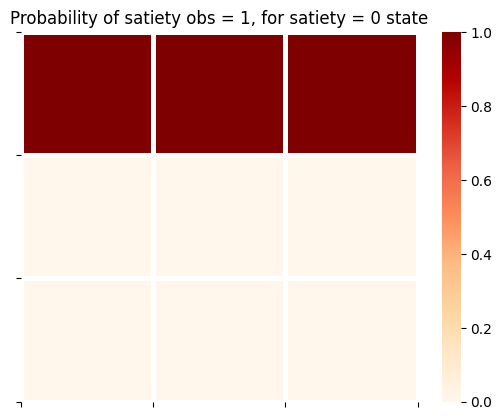

In [ ]:
utils.plot_likelihood(A2[1][:,:,0], title = 'Probability of satiety obs = 1, for satiety = 0 state')

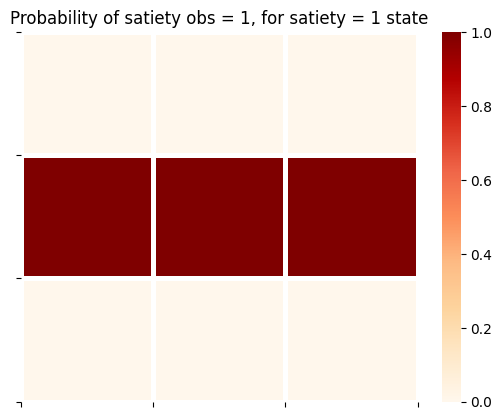

In [ ]:
utils.plot_likelihood(A2[1][:,:,1], title = 'Probability of satiety obs = 1, for satiety = 1 state')

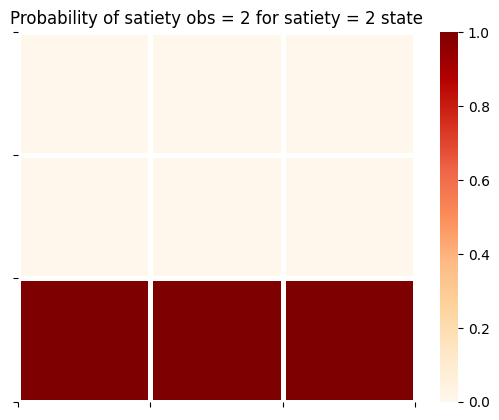

In [ ]:
utils.plot_likelihood(A2[1][:,:,2], title = 'Probability of satiety obs = 2 for satiety = 2 state')

Like above, the agent has satiety 0/1/2 when satiety state is 0/1/2, regardless food left.

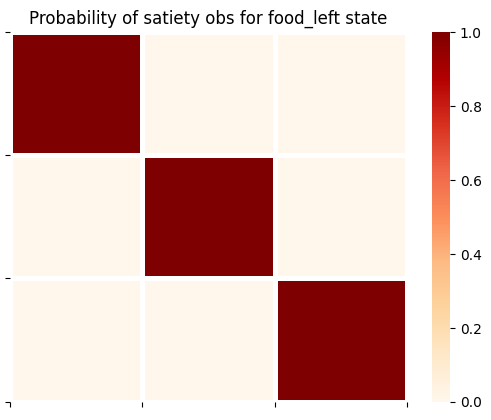

In [ ]:
utils.plot_likelihood(A2[1][:,2,:], title = 'Probability of satiety obs for food_left state')

### Transition model (Planning) - *B matrix*

B matrix is updated: eating when food is available leads to a satiated agent and no food. Not eating results in an increase of food and satiety. The agent must balance immediate satiety with long-term food availability.

In [ ]:
# we need one slice matrix for each state
B2 = utils.initialize_empty_B(num_states, num_states)

In [ ]:
B2

array([array([[[0., 0.],
               [0., 0.]],

              [[0., 0.],
               [0., 0.]]]), array([[[0., 0.],
                                    [0., 0.]],

                                   [[0., 0.],
                                    [0., 0.]]])], dtype=object)

#### Food left state

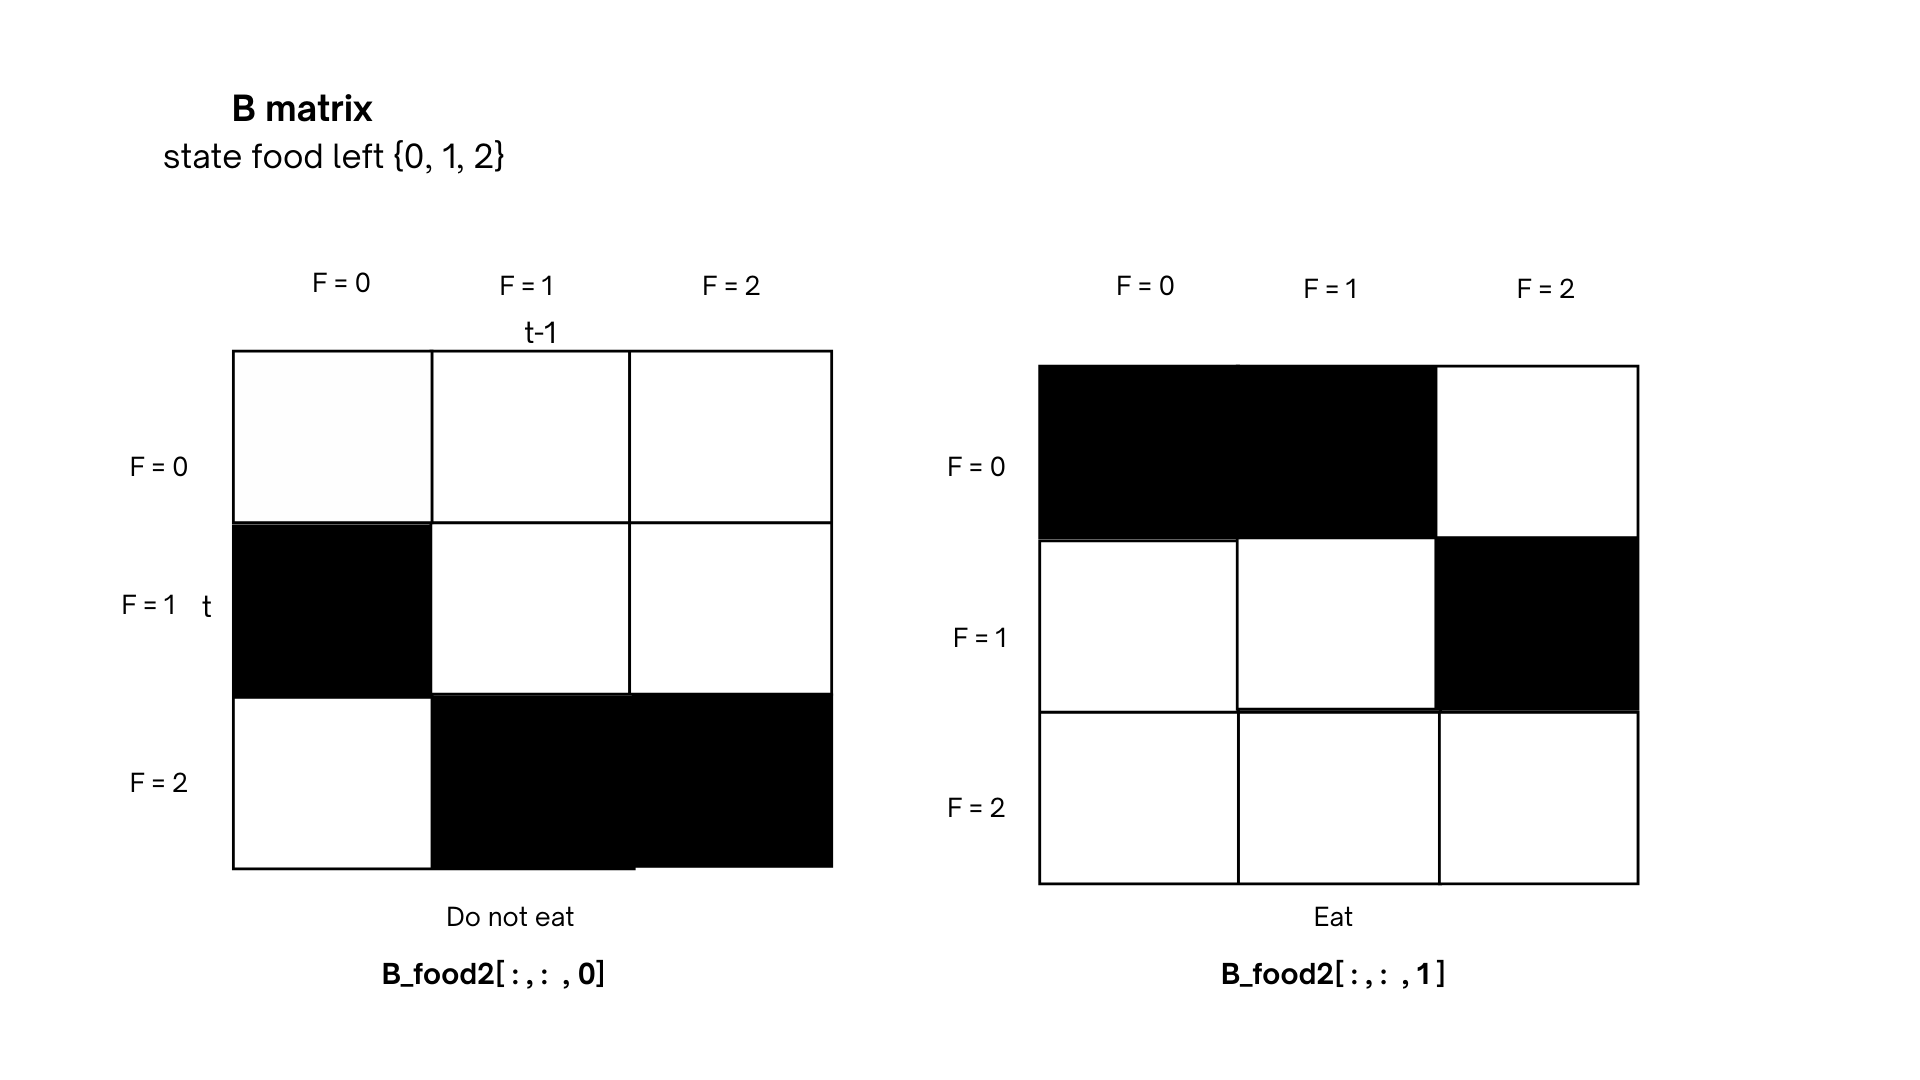

In [ ]:
B_food_left2 = np.zeros( (len(s_food2), len(s_food2), len(choice2)) )

In [ ]:
# Action = do not eat -> B_food_left2[:,:,0]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = 0, state t-1: food left = 0, action = 0 100% prob
B_food_left2[0,0,0] = 0.0

# state t: food left = 1, state t-1: food = 0, action: do not eat (0) should be 0%
B_food_left2[1,0,0] = 1.0

# state t: food left = 2, state t-1: food = 0, action: do not eat (0)
B_food_left2[2,0,0] = 0.0

# state t: food left = 0, state t-1: food = 1, action: 0 should be 0%
B_food_left2[0,1,0] = 0.0

# state t: food left = 1, state t-1: food = 1, action: do not eat (0) should be 100%
B_food_left2[1,1,0] = 0.0

# state t: food left = 2, state t-1: food = 1, action: do not eat (0)
B_food_left2[2,1,0] = 1.0

# state t: food left = 2, state t-1: food = 0, action: do not eat (0)
B_food_left2[2,2,0] = 1.0
print(B_food_left2)

[[[0. 0.]
  [0. 0.]
  [0. 0.]]

 [[1. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [1. 0.]
  [1. 0.]]]


In [ ]:
B_food_left2[:,:,0]

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 1.]])

In [ ]:
B2[0] = B_food_left2

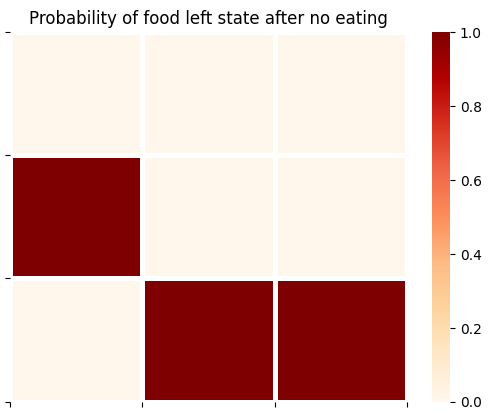

In [ ]:
utils.plot_likelihood(B2[0][:,:,0], title = 'Probability of food left state after no eating' )

If the agent does not eat the food grows in time.

In [ ]:
# Action = eat -> B_food_left2[:,:,1]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = 0, state t-1: food left = 0, action = 1 100% prob
B_food_left2[0,0,1] = 1.0

# state t: food left = 1, state t-1: food = 0, action: eat (1)  should be 0%
B_food_left2[1,0,1] = 0.0

# state t: food left = 2, state t-1: food = 0, action: eat (1)
B_food_left2[2,0,1] = 0.0

# state t: food left = 0, state t-1: food = 1, action: 0 should be 0%
B_food_left2[0,1,1] = 1.0

# state t: food left = 1, state t-1: food = 1, action: eat (1) should be 100%
B_food_left2[1,1,1] = 0.0

# state t: food left = 2, state t-1: food = 1, action: eat (1)
B_food_left2[2,1,1] = 0.0

# state t: food left = 0, state t-1: food left = 2, action = 1 100% prob
B_food_left2[0,2,1] = 0.0

# state t: food left = 1, state t-1: food = 1, action: eat (1)
B_food_left2[1,2,1] = 1.0

# state t: food left = 2, state t-1: food = 0, action: eat (1)
B_food_left2[2,2,1] = 0.0

In [ ]:
B_food_left2[:,:,1]

array([[1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [ ]:
B2[1] = B_food_left2

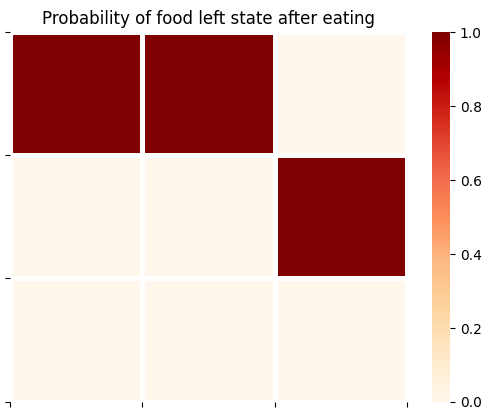

In [ ]:
utils.plot_likelihood(B2[0][:,:,1], title = 'Probability of food left state after eating' )

#### Satiety state

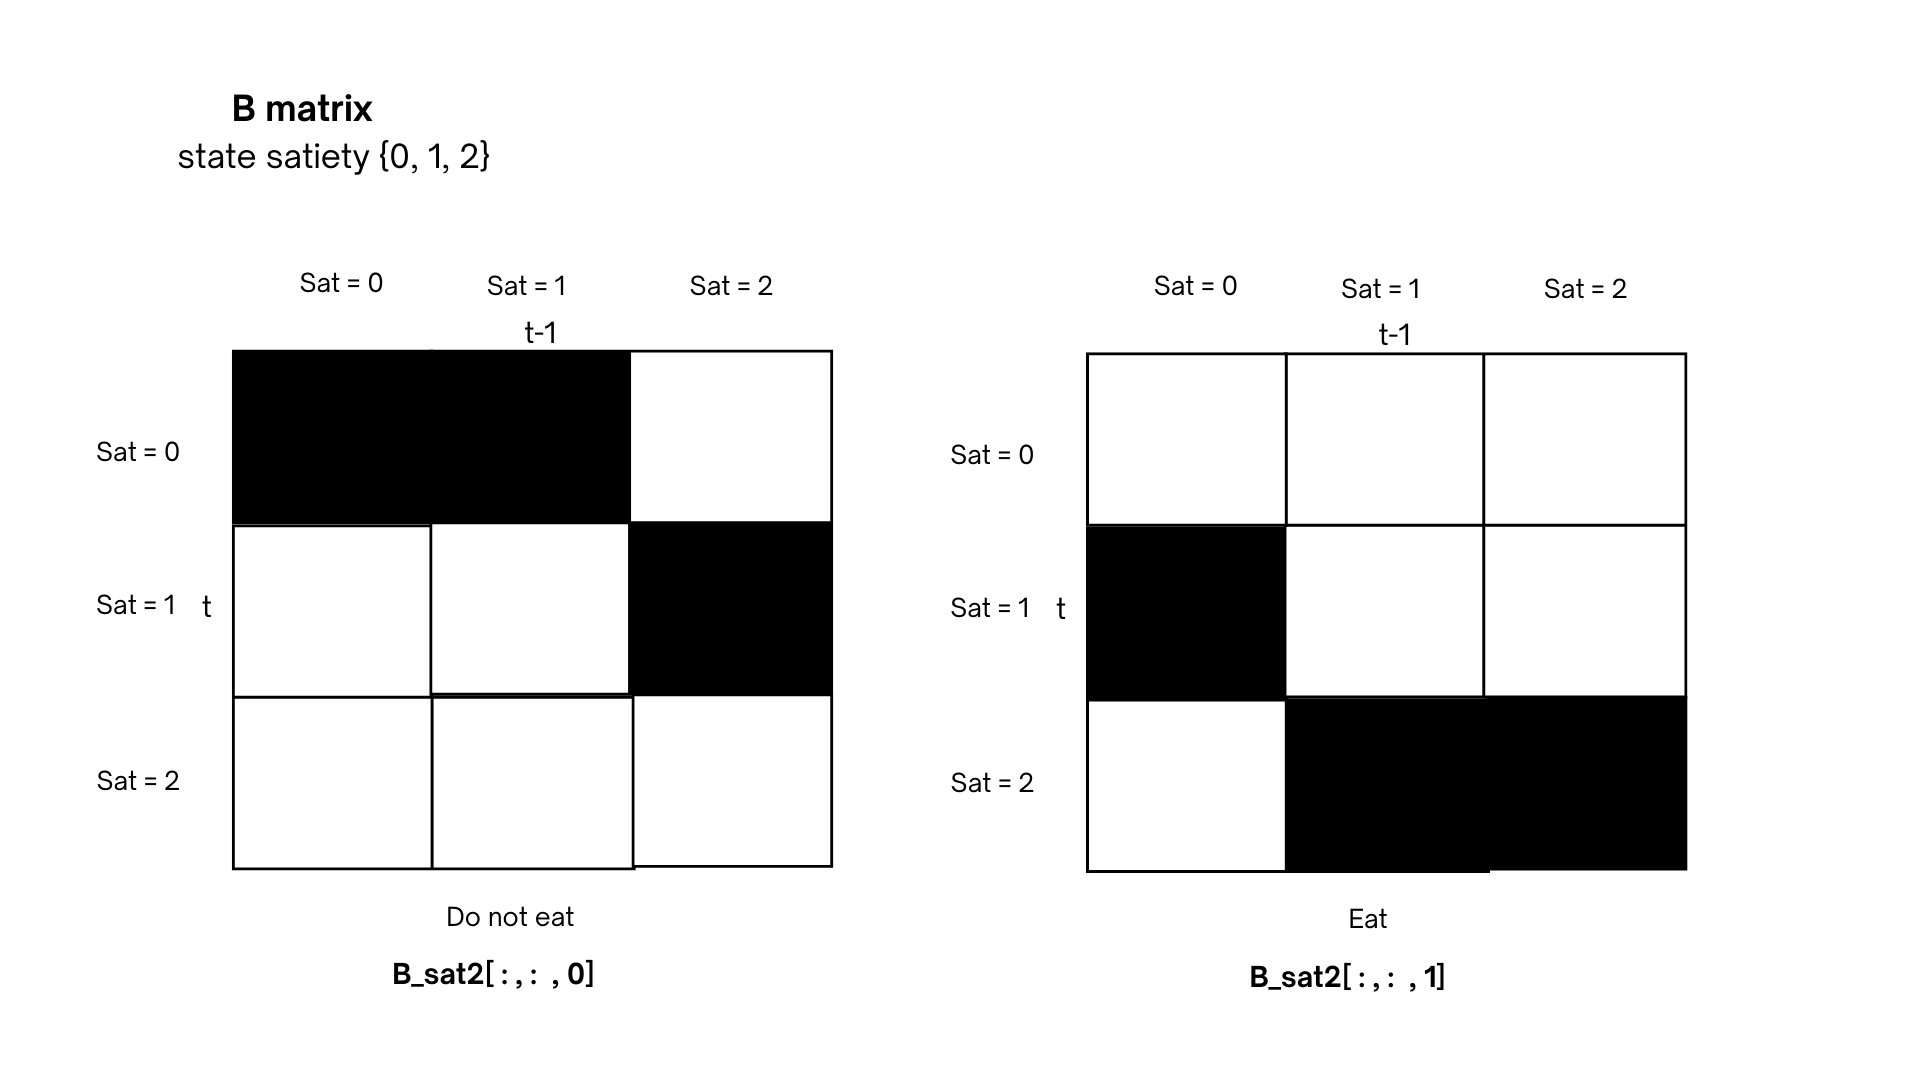

In [ ]:
B_satiety2 = np.zeros((len(s_satiety2), len(s_satiety2), len(choice2)))

In [ ]:
# Action = do not eat -> B_satiety2[:,:,0]

# index 1: state t, index 2: state t-1, index 3: action

# state t: satiety = 0, state t-1: satiety = 0, action = 0 100% prob
B_satiety2[0,0,0] = 1.0

B_satiety2[1,0,0] = 0.0

B_satiety2[2,0,0] = 0.0

B_satiety2[0,1,0] = 1.0

B_satiety2[1,1,0] = 0.0

B_satiety2[2,1,0] = 0.0

B_satiety2[1,2,0] = 1.0

In [ ]:
B2[1] = B_satiety2

In [ ]:
B2[1][:,:,0]

array([[1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

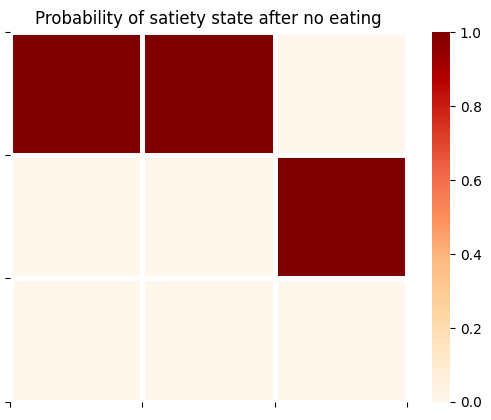

In [ ]:
utils.plot_likelihood(B2[1][:,:,0], title = 'Probability of satiety state after no eating')

In [ ]:
# Action = eat -> B_satiety2[:,:,1]

# index 1: state t, index 2: state t-1, index 3: action

B_satiety2[0,0,1] = 0.0

B_satiety2[1,0,1] = 1.0

# state t: food left = 2, state t-1: food = 0, action: eat (1)
B_satiety2[2,0,1] = 0.0

# state t: food left = 0, state t-1: food = 1, action: 0 should be 0%
B_satiety2[0,1,1] = 0.0

# state t: food left = 1, state t-1: food = 1, action: eat (1) should be 100%
B_satiety2[1,1,1] = 0.0

# state t: food left = 2, state t-1: food = 1, action: eat (1)
B_satiety2[2,1,1] = 1.0

# state t: food left = 0, state t-1: food left = 2, action = 1 100% prob
B_satiety2[0,2,1] = 0.0

# state t: food left = 1, state t-1: food = 1, action: eat (1)
B_satiety2[1,2,1] = 0.0

# state t: food left = 2, state t-1: food = 0, action: eat (1)
B_satiety2[2,2,1] = 1.0

In [ ]:
B2[1] = B_satiety2

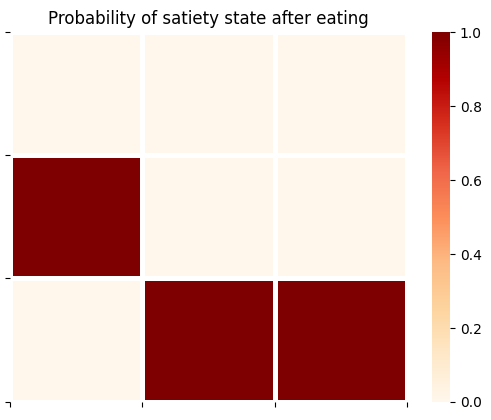

In [ ]:
utils.plot_likelihood(B2[1][:,:,1], title = 'Probability of satiety state after eating')

<ipython-input-293-96dde77e7e67>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


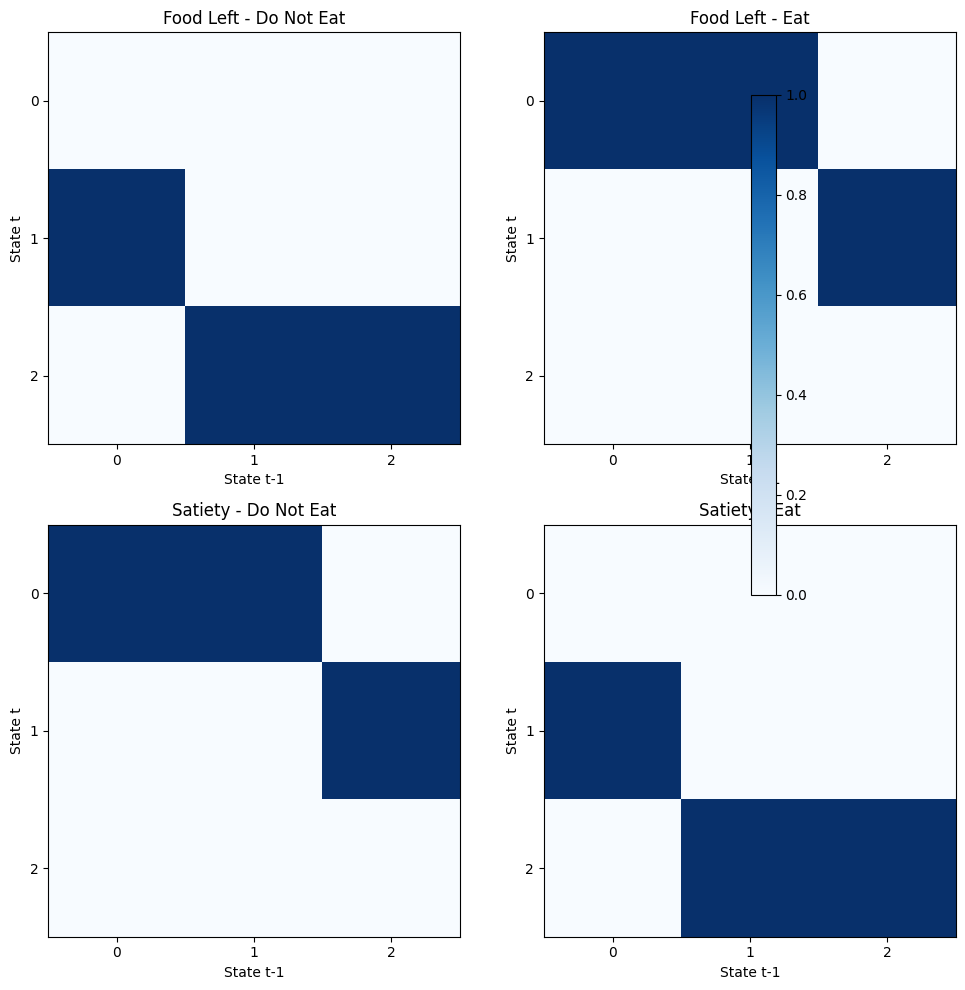

In [ ]:
# plot together
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows for each matrix type, 2 columns for each action

# Titles
actions = ['Do Not Eat', 'Eat']
matrix_types = ['Food Left', 'Satiety']

for i, matrix in enumerate([B2[0], B2[1]]):
    for j in range(2):
        ax = axes[i, j]
        cax = ax.imshow(matrix[:, :, j], cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'{matrix_types[i]} - {actions[j]}')
        ax.set_xlabel('State t-1')
        ax.set_ylabel('State t')
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.set_xticklabels(['0', '1', '2'])
        ax.set_yticklabels(['0', '1', '2'])

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.4, hspace=0.4, wspace=0.4)

# color bar
fig.colorbar(cax, ax=axes.ravel().tolist(), orientation='vertical')
plt.tight_layout()
plt.show()

### Prior preferences and beliefs



#### *C vector*

C vector: satisfying its hunger (maximizing satiety) and maintaining a sustainable food supply. The prior preferences encoded in the C matrix influence this tradeoff.

In [ ]:
# create prior preferences over observations

C2 = utils.obj_array_zeros([num_obs2])

In [ ]:
C2

array([array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]])], dtype=object)

In [ ]:
len(C2)

1

In [ ]:
# not sure about the setting of preferences for average

In [ ]:
# Define preferences for each observation modality
C_food_left2 = np.array([0.0, 20.0, 0.0])  # preference for the observation modality of food 1 <- average value
C_satiety2 = np.array([0.0, 20.0, 0.0])  # preference for the observation modality of satiety 1 <- average value

# create an object array to hold each modality's preferences
C2 = np.empty(2, dtype=object)
C2[0] = C_food_left2
C2[1] = C_satiety2

In [ ]:
C2

array([array([ 0., 20.,  0.]), array([ 0., 20.,  0.])], dtype=object)

In [ ]:
len(C2)

2

In [ ]:
print("C vector:", C2)
for i, pref in enumerate(C2):
    print(f"Preferences for observation modality {i}: {pref}") #modality 0: food_left, 1: satiety

C vector: [array([ 0., 20.,  0.]) array([ 0., 20.,  0.])]
Preferences for observation modality 0: [ 0. 20.  0.]
Preferences for observation modality 1: [ 0. 20.  0.]


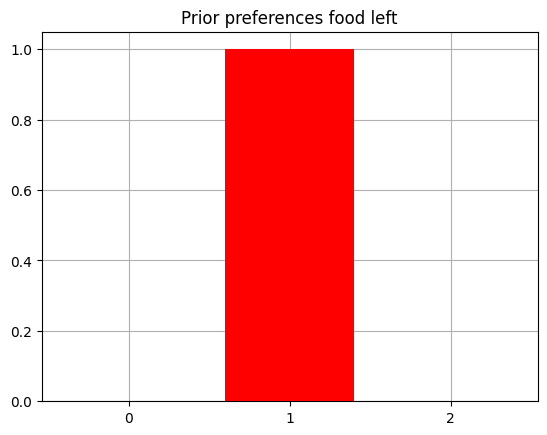

In [ ]:
utils.plot_beliefs(softmax(C2[0]), title = "Prior preferences food left")

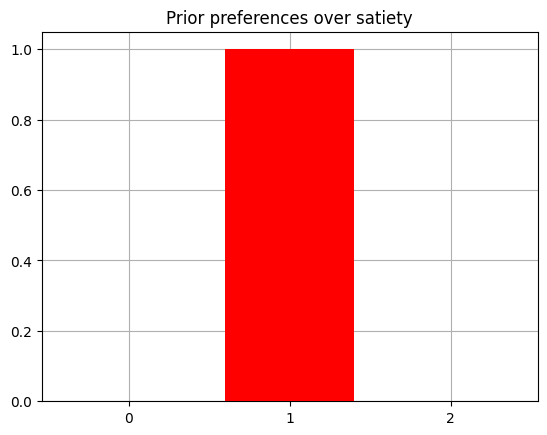

In [ ]:
utils.plot_beliefs(softmax(C2[1]), title = "Prior preferences over satiety")

#### *D vector*

In [ ]:
# specify prior over hidden states (D vector)

D2 = utils.obj_array(num_factors2)

In [ ]:
# we set at t = 0 strong beliefs over hidden state food left = 2 D2[0][:,1,:] and satiety = 0 D2[1][0,:,:]

D_food_left2 = np.array([0.0, 20.0, 20.0])
D_satiety2 = np.array([20.0, 0.0, 0.0])

# create an object array to hold each modality's preferences
D2 = np.empty(2, dtype=object)
D2[0] = D_food_left2
D2[1] = D_satiety2

In [ ]:
print("D vector:", D2)
for i, prior in enumerate(D2):
    print(f"Prior over state factor {i}: {prior}") #factor 0: food left, 1: satiety

D vector: [array([ 0., 20., 20.]) array([20.,  0.,  0.])]
Prior over state factor 0: [ 0. 20. 20.]
Prior over state factor 1: [20.  0.  0.]


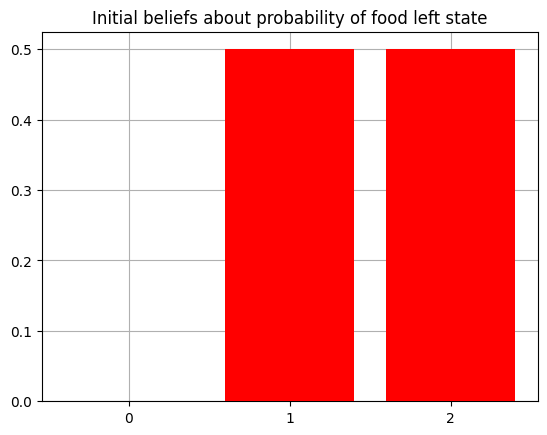

In [ ]:
utils.plot_beliefs(softmax(D2[0]), title = "Initial beliefs about probability of food left state")

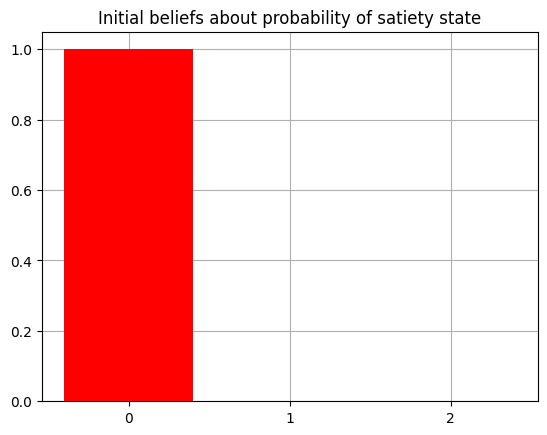

In [ ]:
utils.plot_beliefs(softmax(D2[1]), title = "Initial beliefs about probability of satiety state")

## **Generative Process** - to be fixed

### Agent

In [ ]:
# we set policy_len = 3 because in order to better planning the agent need to look further than just 1 ts
my_agent2 = Agent(A=A2, B=B2, C=C2, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
#my_agent2 = Agent(A=A2, B=B2, C=C2, policy_len = 3, policies=None, action_selection="deterministic")

### AIF loop

In [ ]:
class room_Env2:
    def __init__(self):
        # Initial states
        self.state_food2 = 1  # food = 1 (some)
        self.state_satiety2 = 0  # satiety = 0 (not satisfied)

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        if action == 0:  # do not eat
            # increase food level if agent does not eat
            self.state_food2 = min(self.state_food2 + 1, 2)  # Food level can grow up to 2
            self.state_satiety2 = max(self.state_satiety2 - 1, 0) # satiety decreases

        elif action == 1:  # eat
            if self.state_food2 > 0:  # can only eat if food is present
                # decrease food, increase satiety
                self.state_food2 -= 1
                self.state_satiety2 = min(self.state_satiety2 + 1, 2)

        # mapping states to observations
        obs_food2 = self.state_food2  # Directly use the state as observation
        obs_satiety2 = self.state_satiety2

        return [obs_food2, obs_satiety2]

    def reset(self):
        # reset the environment to the initial state
        self.state_food2 = 1  # Food present
        self.state_satiety2 = 0  # No satiety

        return [self.state_food2, self.state_satiety2]

In [ ]:
def calculate_reward(state, action):
    food, satiety = state
    if action == 1:  # eat
        if food == 1:
            if satiety < 2:  # needs to eat
                return 10  # high reward for eating when needed
            else:
                return -5  # penalty for overeating
        else:
            return -10  # penalty for trying to eat when no food is available
    elif action == 0:  # do not eat
        if satiety == 0:
            return -5  # penalty for not eating when hungry
        else:
            return 5  # reward for not eating when not necessary
    return 0  # neutral reward in other cases

#### all policies - working but wrong results
 satiety level is not average and results change at every run

In [ ]:
len(my_agent2.policies)

64

In [ ]:
env = room_Env2()

# length of active inference loop in time
T = 10

# initialize or reset the environment
current_state = env.reset()

total_reward = 0  # track total reward accumulated by the agent

for t in range(T):
    # sample an observation from the environment
    observation2 = env.step(action) if t > 0 else current_state  # Initial state for the first observation

    # ensure observation is in the correct format
    observation2 = [np.array([obs]) for obs in observation2]

    # update the agent's belief about the current state based on the observation
    qs = my_agent2.infer_states(observation2)  # Update state beliefs

    # infer policies based on the updated beliefs
    my_agent2.infer_policies()  # Now expecting 2 policy values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent2, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_agent2.sample_action()

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # Convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        action = int(action[0])  # Select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

    # calculate reward after action is taken
    reward = calculate_reward(observation2, action)
    total_reward += reward

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation2}, Reward: {reward}")
    print()

# output total accumulated reward
print("Total Reward:", total_reward)

Agent's internal state (posterior over policies - q_pi): [0.00000000e+000 2.04671866e-224 2.04671866e-224 1.92882143e-085
 2.04671866e-224 2.04671866e-224 1.92882143e-085 1.92882143e-085
 2.04671866e-224 1.92882143e-085 2.04671866e-224 1.92882143e-085
 1.92882143e-085 1.92882143e-085 1.92882143e-085 1.92882143e-085
 8.79058972e-215 1.76853996e-140 8.28422494e-076 1.66666667e-001
 4.11770298e-150 4.36939336e-289 3.88051073e-011 4.11770298e-150
 8.28422494e-076 1.66666667e-001 8.28422494e-076 1.66666667e-001
 3.88051073e-011 4.11770298e-150 3.88051073e-011 4.11770298e-150
 2.04671866e-224 1.92882143e-085 2.04671866e-224 1.92882143e-085
 1.92882143e-085 1.92882143e-085 1.92882143e-085 1.92882143e-085
 2.04671866e-224 1.92882143e-085 0.00000000e+000 2.04671866e-224
 1.92882143e-085 1.92882143e-085 2.04671866e-224 2.04671866e-224
 8.28422494e-076 1.66666667e-001 8.28422494e-076 1.66666667e-001
 3.88051073e-011 4.11770298e-150 3.88051073e-011 4.11770298e-150
 8.28422494e-076 1.66666667e-001 

In [ ]:
type(observation2)

list

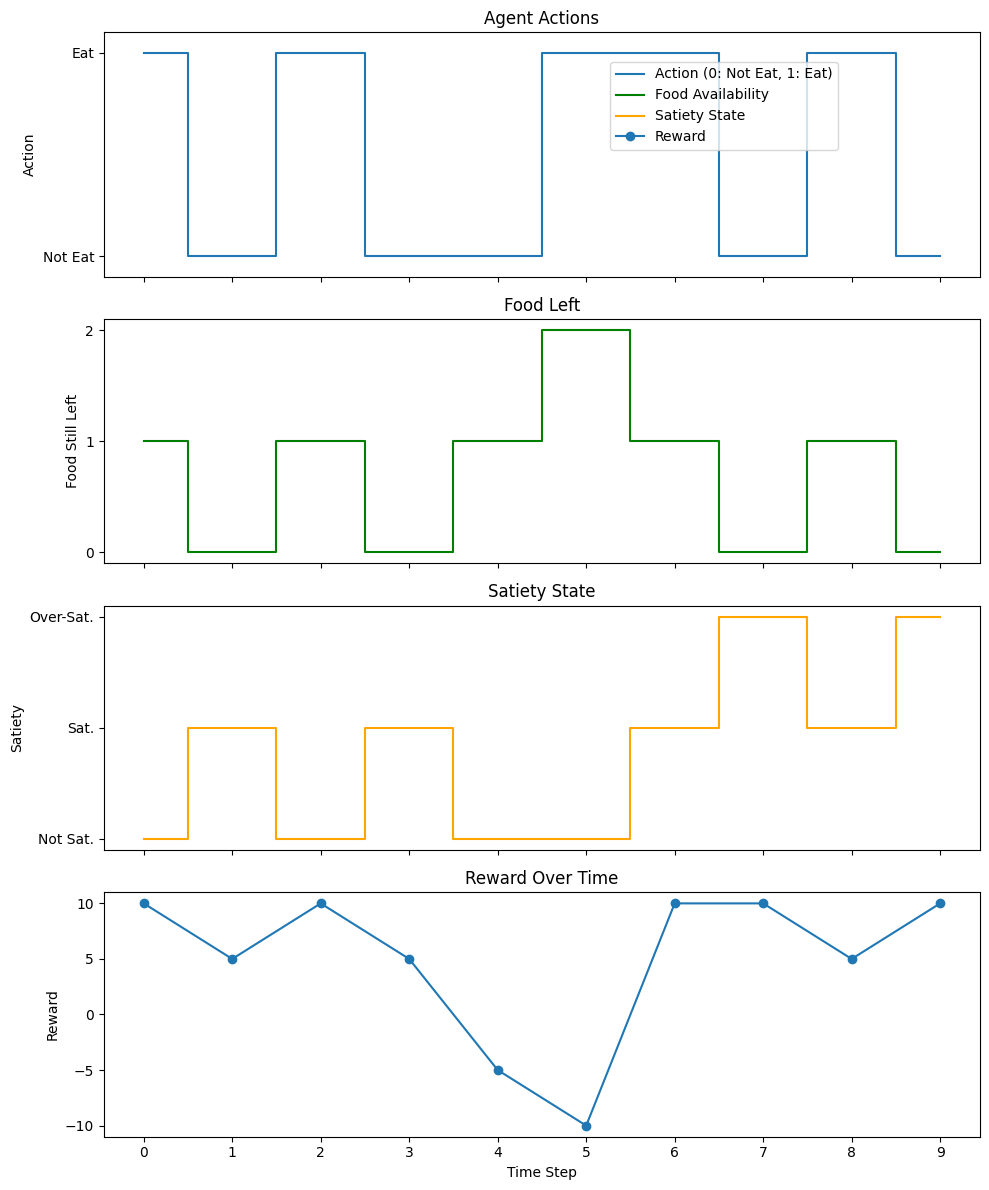

In [ ]:
# Time steps
T = 10

# Simulation output data
actions = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])  # Actions taken by the agent
observations_food = np.array([1, 0, 1, 0, 1, 2, 1, 0, 1, 0])  # Food availability observed
observations_satiety = np.array([0, 1, 0, 1, 0, 0, 1, 2, 1, 2])  # Satiety state observed
rewards = np.array([10, 5, 10, 5, -5, -10, 10, 10, 5, 10])  # Rewards received

# Creating the plot
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plotting actions
ax[0].step(range(T), actions, label='Action (0: Not Eat, 1: Eat)', where='mid')
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_ylabel("Action")
ax[0].set_title("Agent Actions")
ax[0].set_yticks([0, 1])
ax[0].set_yticklabels(["Not Eat", "Eat"])

# Plotting food observations
ax[1].step(range(T), observations_food, label='Food Availability', where='mid', color='green')
ax[1].set_ylim(-0.1, 2.1)
ax[1].set_ylabel("Food Still Left")
ax[1].set_title("Food Left")
ax[1].set_yticks([0, 1, 2])
ax[1].set_yticklabels(["0", "1", "2"])

# Plotting satiety observations
ax[2].step(range(T), observations_satiety, label='Satiety State', where='mid', color='orange')
ax[2].set_ylim(-0.1, 2.1)
ax[2].set_ylabel("Satiety")
ax[2].set_title("Satiety State")
ax[2].set_yticks([0, 1, 2])
ax[2].set_yticklabels(["Not Sat.", "Sat.", "Over-Sat."])

# Plotting rewards
ax[3].plot(range(T), rewards, label='Reward', marker='o', linestyle='-')
ax[3].set_ylabel("Reward")
ax[3].set_title("Reward Over Time")

# Setting x-axis properties
plt.xlabel("Time Step")
plt.xticks(range(T))

# Adding a legend
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.95))

plt.tight_layout()
plt.show()

#### reduced policies - not working

In [ ]:
 pol = my_agent2.policies

In [ ]:
 len(pol) # should be reduced to 8 policies <- 2(actions)power3(steps ahead)

64

In [ ]:
# restrict policies to just be the ones which action[0]=action[1]

def restrict_policies(policies):
    restricted_policies = []
    for policy in pol:
        # Check if all actions in the policy are the same
        if np.all(policy == policy[0, 0]):
            restricted_policies.append(policy)
    return restricted_policies

In [ ]:
restricted_policies_case_2 = restrict_policies(pol)

In [ ]:
my_agent2.policies = restricted_policies_case_2

# to adjust matrix size after having reduced policies
my_agent2.E = my_agent2._construct_E_prior()

In [ ]:
my_agent2.policies # we should have 8 policies

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
env = room_Env2()

total_reward = 0  # Track total reward accumulated by the agent

for t in range(T):
    # Sample an observation from the environment
    observation = env.step(action) if t > 0 else current_state  # Initial state for the first observation

    # Update the agent's belief about the current state based on the observation
    qs = my_agent2.infer_states([observation])  # Update state beliefs

    # Infer policies based on the updated beliefs
    my_agent2.infer_policies()  # Now expecting 2 policy values

    # Debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent2, 'q_pi', 'Attribute not set'))

    # Sample the next action from the inferred policies
    action = my_agent2.sample_action()

    # Handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # Convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        action = int(action[0])  # Select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

    # Calculate reward after action is taken
    reward = calculate_reward(observation, action)
    total_reward += reward

    # Results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}, Reward: {reward}")
    print()

# Output total accumulated reward
print("Total Reward:", total_reward)

IndexError: tuple index out of range

In [ ]:
# initial observation is wrong, should be 1, 0

In [ ]:
# Time steps
T = 10

# Simulation output data
actions = np.array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1])  # Actions taken by the agent
observations_food = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # Food availability observed
observations_satiety = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # Satiety state observed
rewards = np.array([-10, 5, -10, -10, 5, -10, -10, -10, 5, -10])  # Rewards received

# Creating the plot
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plotting actions
ax[0].step(range(T), actions, label='Action (0: Not Eat, 1: Eat)', where='mid')
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_ylabel("Action")
ax[0].set_title("Agent Actions")
ax[0].set_yticks([0, 1])
ax[0].set_yticklabels(["Not Eat", "Eat"])

# Plotting food observations
ax[1].step(range(T), observations_food, label='Food Availability', where='mid', color='green')
ax[1].set_ylim(-0.1, 2.1)
ax[1].set_ylabel("Food Still Left")
ax[1].set_title("Food Left")
ax[1].set_yticks([0, 1, 2])
ax[1].set_yticklabels(["0", "1", "2"])

# Plotting satiety observations
ax[2].step(range(T), observations_satiety, label='Satiety State', where='mid', color='orange')
ax[2].set_ylim(-0.1, 2.1)
ax[2].set_ylabel("Satiety")
ax[2].set_title("Satiety State")
ax[2].set_yticks([0, 1, 2])
ax[2].set_yticklabels(["Not Sat.", "Sat.", "Over-Sat."])

# Plotting rewards
ax[3].plot(range(T), rewards, label='Reward', marker='o', linestyle='-')
ax[3].set_ylabel("Reward")
ax[3].set_title("Reward Over Time")

# Setting x-axis properties
plt.xlabel("Time Step")
plt.xticks(range(T))

# Adding a legend
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.95))

plt.tight_layout()
plt.show()
